In [1]:
# 3803ICT_Assignment
# Wui Theam Wong - s5132262
# Import appropriate libraries - most of these are to be used later with some other libraries imported when needed
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns
from sklearn.cluster import KMeans
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools
from pylab import rcParams
import pmdarima as pm
import re

In [2]:
# Read in csv data file
data = pd.read_csv("data.csv", low_memory=False)

In [3]:
# Display data variables and their types
data.dtypes

Id                   object
Title                object
Company              object
Date                 object
Location             object
Area                 object
Classification       object
SubClassification    object
Requirement          object
FullDescription      object
LowestSalary          int64
HighestSalary         int64
JobType              object
dtype: object

In [4]:
# Part 1: Data Preparation and Preprocessing
# Delete any rows where any variable is missing a variable(NaN)
data = data[data['Id'].notna()]
data = data[data['Title'].notna()]
data = data[data['Company'].notna()]
data = data[data['Date'].notna()]
data = data[data['Location'].notna()]
data = data[data['Area'].notna()]
data = data[data['Classification'].notna()]
data = data[data['SubClassification'].notna()]
data = data[data['Requirement'].notna()]
data = data[data['FullDescription'].notna()]
data = data[data['LowestSalary'].notna()]
data = data[data['HighestSalary'].notna()]
data = data[data['JobType'].notna()]


In [5]:
# Clean data by removing columns which won't be used
del data["Id"]
# Format FullDescription removing html formats from the text
# Create function to remove the html tags from the descriptions
def del_html(string):
    import re
    # Clean FullDescription by removing all html tags, newline characters, and asterisks present in the strings
    filtered = re.compile('<.*?>|&nbsp;|&amp;|\u260e|\n|[*]', re.DOTALL|re.M)
    return re.sub(filtered, '', string)
data['FullDescription'] = data['FullDescription'].apply(del_html)
data.head()

,Title,Company,Date,Location,Area,Classification,SubClassification,Requirement,FullDescription,LowestSalary,HighestSalary,JobType
121,Fabricator/Installer,WORKPLACE ACCESS & SAFETY,2018-10-07T00:00:00.000Z,Melbourne,Bayside & South Eastern Suburbs,Trades & Services,Welders & Boilermakers,Trade qualified person with skills in welding ...,Secure long term role with genuine ca...,0,30,Full Time
122,Boilermaker,RPM Contracting QLD P/l,2018-10-07T00:00:00.000Z,Brisbane,Southern Suburbs & Logan,Trades & Services,Welders & Boilermakers,Perm rate $30. Structural steel fab & weld out...,One of Australia's best engineering workshops ...,0,30,Full Time
125,Casual Childcare Positions | Bondi Junction,anzuk Education,2018-10-07T00:00:00.000Z,Sydney,"CBD, Inner West & Eastern Suburbs",Education & Training,Teaching - Early Childhood,"anzuk education are searching for reliable, en...",What is anzuk? anzuk Early Childhoodis a rec...,0,30,Contract/Temp
126,Technician,Zoom Recruitment & Training,2018-10-07T00:00:00.000Z,Sydney,South West & M5 Corridor,Engineering,Mechanical Engineering,"This Australian Icon, connects the people of t...","This Australian Icon, connects the people of t...",0,30,Full Time
127,Systems Engineer,Humanised Group,2018-10-07T00:00:00.000Z,Brisbane,CBD & Inner Suburbs,Information & Communication Technology,Networks & Systems Administration,Systems Engineer to work on BAU/Projects for a...,The Company This organisation is well-establi...,0,30,Full Time


In [6]:
# Normalize the data by converting Date from object to Datetime data type
data['Date'] = pd.to_datetime(data['Date'])
data.dtypes

Title                             object
Company                           object
Date                 datetime64[ns, UTC]
Location                          object
Area                              object
Classification                    object
SubClassification                 object
Requirement                       object
FullDescription                   object
LowestSalary                       int64
HighestSalary                      int64
JobType                           object
dtype: object

In [7]:
# Part 2: Data Analysis and Intepretation
# Question 1: Job Metadata
# Find all job Classification and SubClassifications
# Extract the job title, classification, and subclassification
data1 = data[['Title','Classification','SubClassification']].copy()
# Group the Classification and subclassification to measure classification and subclassification count
data1 = data1.groupby(['Classification','SubClassification']).size().reset_index().rename(columns={0:'Count'})

#The following line of code is to display each Sub Classification by popularity within their own Classifications
data1 = data1.sort_values(by=['Classification','Count'], ascending=False)

data1 = data1.reset_index()
print(data1.to_string())


     index                          Classification                                SubClassification  Count
0      372                       Trades & Services                                Automotive Trades   1601
1      378                       Trades & Services                                     Electricians    806
2      383                       Trades & Services                                        Labourers    691
3      379                       Trades & Services                    Fitters, Turners & Machinists    621
4      382                       Trades & Services                           Hair & Beauty Services    601
5      394                       Trades & Services                           Welders & Boilermakers    546
6      393                       Trades & Services                                      Technicians    526
7      376                       Trades & Services                       Carpentry & Cabinet Making    524
8      381                       Trad

In [8]:
# Determine most popular job Classification and SubClassifications
# Extract the job title, classification, and subclassification
data2 = data[['Title','Classification','SubClassification']]
# Group the Classification and subclassification to measure classification and subclassification count
data2 = data2.groupby(['Classification','SubClassification']).size().reset_index().rename(columns={0:'Count'})

#Sort classifications by the counts - this shows the most popular sub classifications
data2 = data2.sort_values(by=['Count'], ascending=False)

data2 = data2.reset_index()
print(data2.to_string())

     index                          Classification                                SubClassification  Count
0      234  Information & Communication Technology                           Developers/Programmers   2869
1       25         Administration & Office Support                        Administrative Assistants   2624
2      300    Manufacturing, Transport & Logistics              Warehousing, Storage & Distribution   2499
3      207                   Hospitality & Tourism                                      Chefs/Cooks   2429
4      347              Retail & Consumer Products                                Retail Assistants   2170
5      230  Information & Communication Technology                        Business/Systems Analysts   1878
6      354                                   Sales                Sales Representatives/Consultants   1838
7      166                    Government & Defence                               Government - State   1762
8      217                   Hospital

In [9]:
# Determine number of jobs in each location
data3 = data[['Title','Location','Area']].copy()

# Determine the locations were most of the jobs are located and sort the locations.
data3 = data3.groupby(['Location']).size().reset_index().rename(columns={0:'Count'})
data3 = data3.sort_values(by=['Count'], ascending=False)
data3 = data3.reset_index()


print(data3.to_string())


   index   Location  Count
0      3     Sydney  49174
1      1  Melbourne  37156
2      0   Brisbane  15658
3      2      Perth   9121


In [10]:
# Show all jobs, their locations, and areas
data4 = data[['Title','Location','Area']].copy()

# The following two lines of code is to show the most popular areas in each location for each job
data4 = data4.groupby(['Title','Location','Area']).size().reset_index().rename(columns={0:'Count'})

# Show all jobs in each location and area then order them by count
data4 = data4.sort_values(by=['Location', 'Area','Count'], ascending=False)
data4 = data4.reset_index()

# If printing all rows of dataset
#print(data2.to_string())

# Showcase of top of data to diplay part of the output
data4.head()

,index,Title,Location,Area,Count
0,63472,Senior Commercial Manager - Sales,Sydney,Southern Suburbs & Sutherland Shire,10
1,2652,Administration Assistant,Sydney,Southern Suburbs & Sutherland Shire,9
2,23700,Early Childhood Teacher,Sydney,Southern Suburbs & Sutherland Shire,7
3,30225,Full time Cook in Brighton-Le-Sands,Sydney,Southern Suburbs & Sutherland Shire,7
4,5347,Assistant Store Manager,Sydney,Southern Suburbs & Sutherland Shire,6


In [11]:
# Determine top Job locations
data5 = data[['Title','Location','Area']].copy()

# Group the jobs in the same locations, and areas together and count occurances
data5 = data5.groupby(['Title','Location','Area']).size().reset_index().rename(columns={0:'Count'})

# Show top most popular jobs by count
data5 = data5.sort_values(by=['Count'], ascending=False)
data5 = data5.reset_index()

# If printing all rows of dataset
#print(data2.to_string())

# Showcase of top of data to diplay part of the output
data5.head()

,index,Title,Location,Area,Count
0,53596,Project Manager,Sydney,"CBD, Inner West & Eastern Suburbs",137
1,53588,Project Manager,Melbourne,CBD & Inner Suburbs,115
2,8206,Business Analyst,Sydney,"CBD, Inner West & Eastern Suburbs",90
3,62953,Senior Business Analyst,Sydney,"CBD, Inner West & Eastern Suburbs",88
4,8723,Business Development Manager,Sydney,"CBD, Inner West & Eastern Suburbs",82


In [12]:
# Find range of salaries for each job
data6 = data[['Title','LowestSalary','HighestSalary']].copy()
data6 = data6.groupby(['Title','LowestSalary','HighestSalary']).size().reset_index().rename(columns={0:'Count'})
# Sort both Lowest and Highest Salary - this shows the highest paying jobs and also sort by number of entries
data6 = data6.sort_values(by=['LowestSalary', 'HighestSalary', 'Count'], ascending=False)
data6 = data6.reset_index()

# If printing all rows of dataset
#print(data3.to_string())

# Showcase top of data instead of all the other data
print("Top 5 highest paying jobs (sorted by occurances)")
print(data6.head(5))

# Show number of occurances for each salary range
data6b = data[['LowestSalary','HighestSalary']].copy()
data6b = data6b.groupby(['LowestSalary','HighestSalary']).size().reset_index().rename(columns={0:'Count'}).sort_values(by=['Count'], ascending=False).reset_index()
print("\nSalary ranges and their occurances (sorted by count)")
print(data6b.to_string())



Top 5 highest paying jobs (sorted by occurances)
   index                    Title  LowestSalary  HighestSalary  Count
0  55696          Project Manager           200            999     73
1  68719   Senior Project Manager           200            999     51
2  65506  Senior Business Analyst           200            999     40
3  14311  Chief Financial Officer           200            999     30
4  32687     General Practitioner           200            999     30

Salary ranges and their occurances (sorted by count)
    index  LowestSalary  HighestSalary  Count
0       0             0             30  19993
1       2            40             50  12025
2       4            60             70  10521
3       7           100            120  10043
4       3            50             60   9859
5       5            70             80   9730
6       9           150            200   9343
7       8           120            150   9008
8       1            30             40   8767
9       6        

In [13]:
# Question 2: Studying market by Locations
# Market size in each city - most common sectors in each city
data7 = data[['Classification','Location']].copy()
data7 = data7.groupby(['Classification','Location']).size().reset_index().rename(columns={0:'Count'})
data7 = data7.sort_values(by=['Count'], ascending=False).drop_duplicates(['Location'])
data7 = data7.reset_index()

# If printing all rows of dataset
#print(data4.to_string())

# Showcase top of data instead of all the other data
data7.head()


,index,Classification,Location,Count
0,71,Information & Communication Technology,Sydney,7501
1,69,Information & Communication Technology,Melbourne,4539
2,68,Information & Communication Technology,Brisbane,1900
3,118,Trades & Services,Perth,1020


JobType    Casual/Vacation  Contract/Temp  Full Time  Part Time
Location                                                       
Brisbane         48.570580     130.156524  86.628656  57.439423
Melbourne        46.777455     124.479510  88.066791  52.707847
Perth            55.041254     108.622647  89.906320  55.882632
Sydney           47.068997     155.617392  95.417925  54.328911


<AxesSubplot:title={'center':'Average Salary for each JobType in each City'}, xlabel='Locations', ylabel='Salary(Average)'>

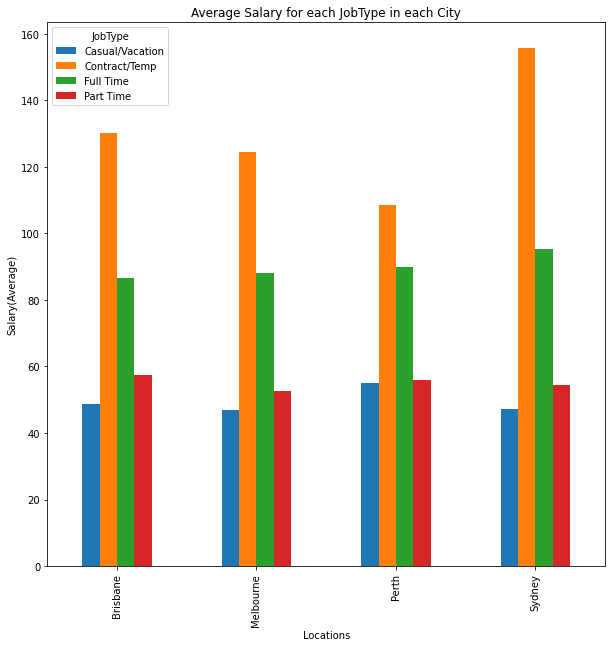

In [14]:
# Range of salary in each city based on job type
data8 = data[['Location','LowestSalary','HighestSalary','JobType']].copy()
data8['AverageSalary'] = (data8['LowestSalary'] + data8['HighestSalary']) / 2

# Sort and create a pivot table to get the average of every job type in every city.
data8b = data8.pivot_table(index='Location', columns='JobType', values='AverageSalary')
print(data8b)
# Plot data
data8.pivot_table(index='Location', columns='JobType', values='AverageSalary').plot(kind='bar',figsize=(10,10),ylabel='Salary(Average)',xlabel='Locations',title='Average Salary for each JobType in each City')


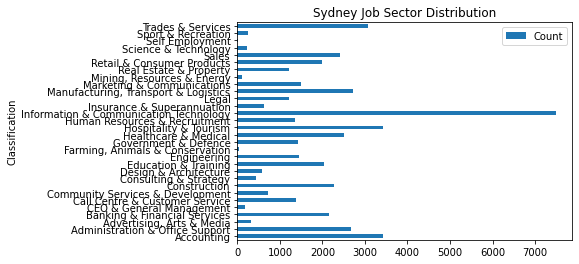

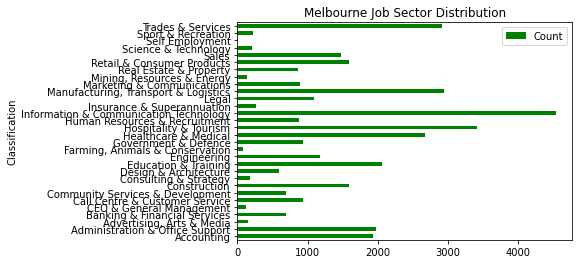

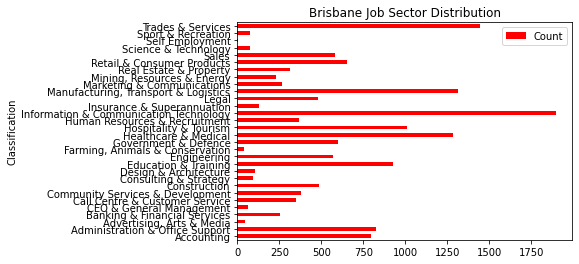

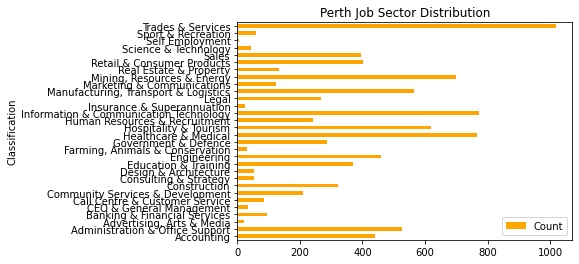

In [15]:
# Show the job distribution in each city - Which cities have the most of what Sectors/Jobs
data9 = data[['Date','Location','Classification']].copy()

# Seperate each row by their location and group sectors together, graph the results
data9syd = data9.loc[data9['Location'] == 'Sydney'].groupby(['Classification']).size().reset_index().rename(columns={0:'Count'}).plot.barh(x='Classification',y='Count',stacked=True, title="Sydney Job Sector Distribution")
data9mel = data9.loc[data9['Location'] == 'Melbourne'].groupby(['Classification']).size().reset_index().rename(columns={0:'Count'}).plot.barh(x='Classification',y='Count',stacked=True, title="Melbourne Job Sector Distribution", color='green')
data9bri = data9.loc[data9['Location'] == 'Brisbane'].groupby(['Classification']).size().reset_index().rename(columns={0:'Count'}).plot.barh(x='Classification',y='Count',stacked=True, title="Brisbane Job Sector Distribution",color='red')
data9per = data9.loc[data9['Location'] == 'Perth'].groupby(['Classification']).size().reset_index().rename(columns={0:'Count'}).plot.barh(x='Classification',y='Count',stacked=True, title="Perth Job Sector Distribution",color='orange')


Date
October     67141
November    23402
December    20566
Name: Count, dtype: int64
                        Date  Count
0  2018-10-01 00:00:00+00:00    612
1  2018-10-02 00:00:00+00:00   1170
2  2018-10-03 00:00:00+00:00   2842
3  2018-10-04 00:00:00+00:00   4877
4  2018-10-05 00:00:00+00:00   3518
5  2018-10-06 00:00:00+00:00    315
6  2018-10-07 00:00:00+00:00    527
7  2018-10-08 00:00:00+00:00   3184
8  2018-10-09 00:00:00+00:00   3633
9  2018-10-10 00:00:00+00:00   5029
10 2018-10-11 00:00:00+00:00    709
11 2018-10-12 00:00:00+00:00    744
12 2018-10-13 00:00:00+00:00    129
13 2018-10-14 00:00:00+00:00    144
14 2018-10-15 00:00:00+00:00   3050
15 2018-10-16 00:00:00+00:00   3696
16 2018-10-17 00:00:00+00:00   7759
17 2018-10-18 00:00:00+00:00   4584
18 2018-10-19 00:00:00+00:00   3575
19 2018-10-20 00:00:00+00:00    261
20 2018-10-21 00:00:00+00:00    603
21 2018-10-22 00:00:00+00:00    417
22 2018-10-23 00:00:00+00:00    476
23 2018-10-24 00:00:00+00:00    481
24 2018-10-25 0

<AxesSubplot:title={'center':'Job postings per date'}, xlabel='Date', ylabel='Number of job postings'>

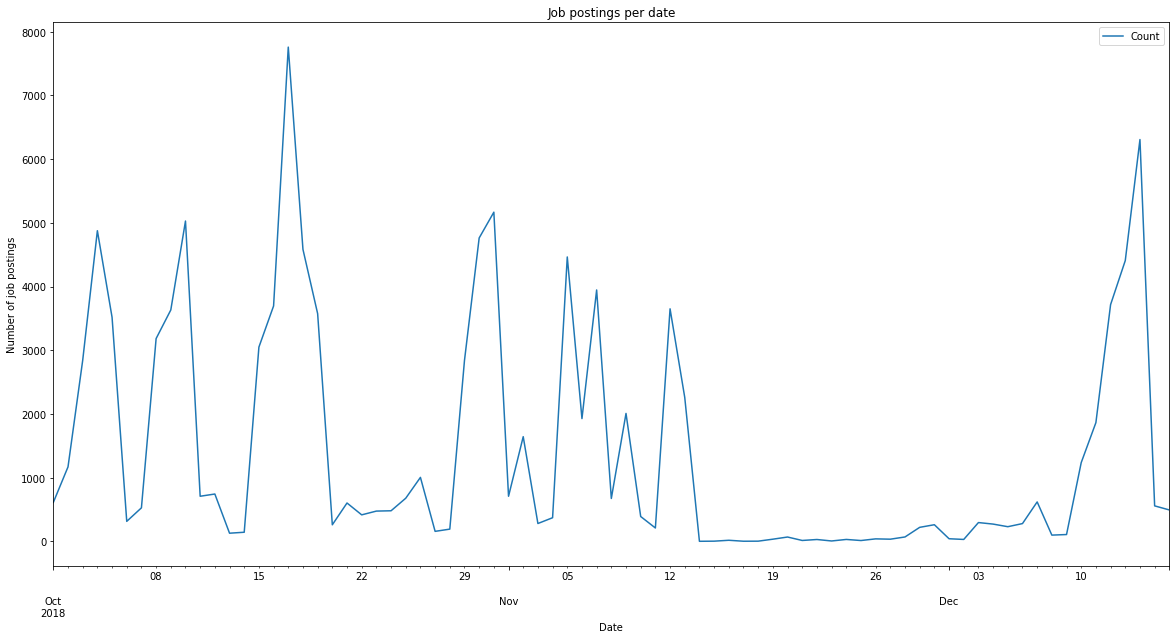

In [16]:
# Detecting pattern of posting -> How many job posting every day over a certain period of time
# Get dates and sort them
data10 = data[['Date']].copy()
data10 = data10.groupby(['Date']).size().reset_index().rename(columns={0:'Count'})
data10 = data10.sort_values(by=['Date'], ascending=True)

# Display total listings for each month
data10b = data10
data10b = data10b.groupby(data10b['Date'].dt.strftime('%B'))['Count'].sum().sort_values(ascending=False)

# If printing all rows of dataset
print(data10b.head())

print(data10.to_string())
# Plot the data of job listing counts each day
data10.plot(x='Date',y='Count',kind='line',figsize=(20,10),ylabel='Number of job postings',xlabel='Date',title='Job postings per date')


    index                          Classification  Entries  Overall Market Share (%)
0      17  Information & Communication Technology    14713                 13.241952
1      15                   Hospitality & Tourism     8471                  7.624045
2      29                       Trades & Services     8450                  7.605144
3      20    Manufacturing, Transport & Logistics     7542                  6.787929
4      14                    Healthcare & Medical     7223                  6.500824
5       0                              Accounting     6595                  5.935613
6       1         Administration & Office Support     6000                  5.400103
7      10                    Education & Training     5385                  4.846592
8      25                                   Sales     4862                  4.375883
9       7                            Construction     4671                  4.203980
10     24              Retail & Consumer Products     4622       

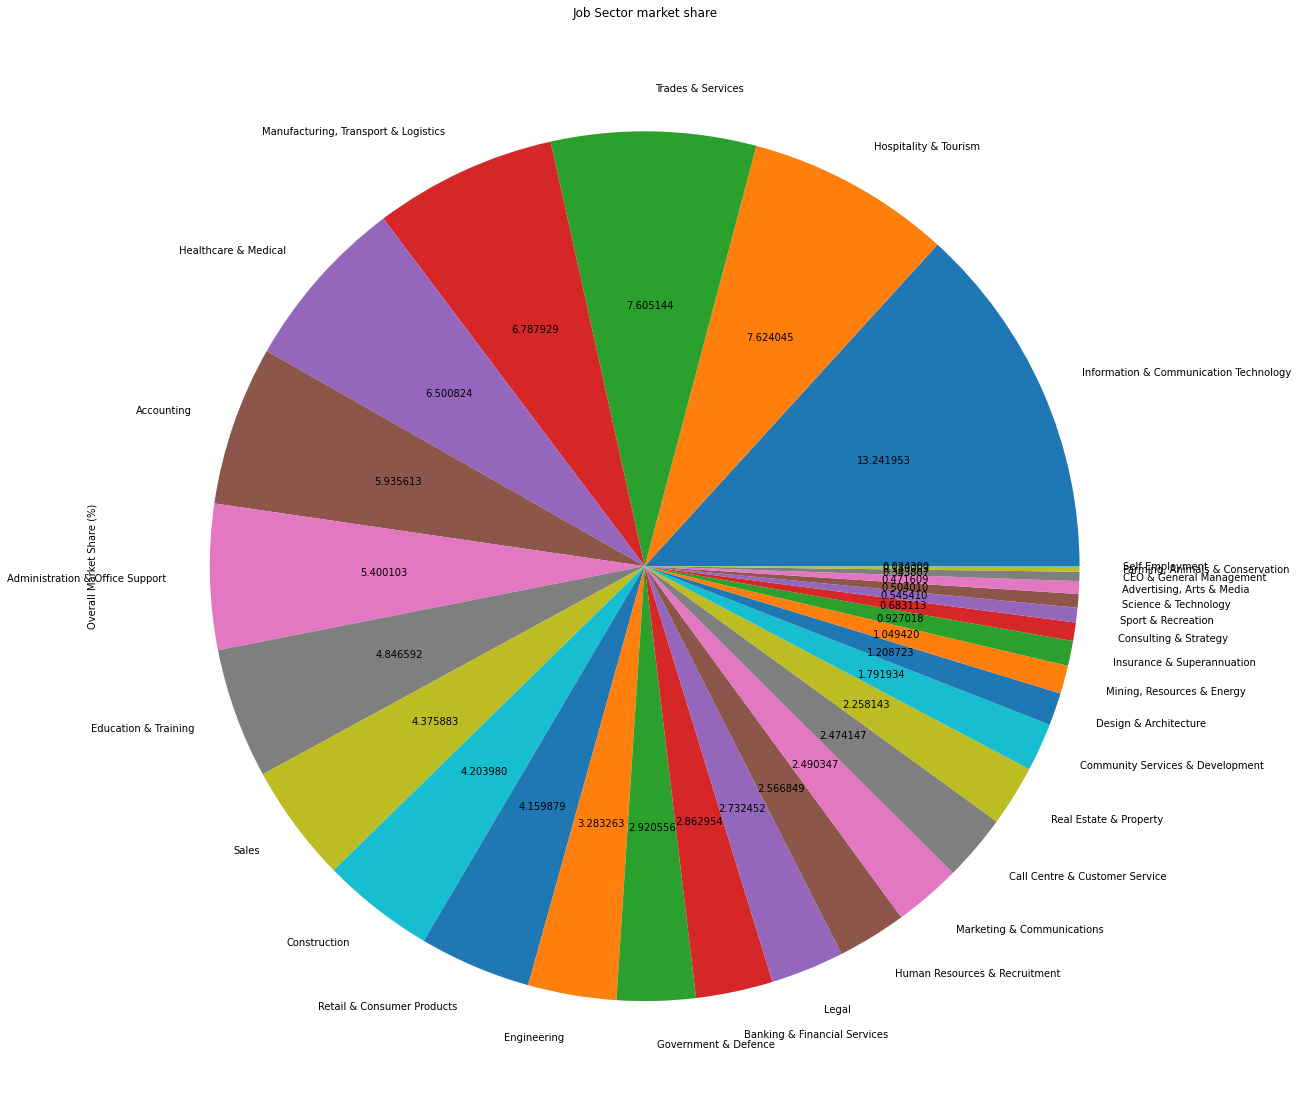

In [17]:
# Question 3: Studying the market by Sectors
# Check which sectors have the highest market share
data11 = data[['Classification']].copy()
data11 = data11.groupby(['Classification']).size().reset_index().rename(columns={0:'Entries'}).sort_values(by=['Entries'], ascending=False).reset_index() 

# Calculate the percentage of overall market share
data11['Overall Market Share (%)'] = data11['Entries']/data11['Entries'].sum()*100
print(data11.to_string())
# Plot data calculated
data11 = data11.set_index('Classification')
data11.plot.pie(x='Classification',y='Overall Market Share (%)' ,figsize=(20,20),title='Job Sector market share',autopct='%f').get_legend().remove()

In [18]:
# In each Classification which Sub Classifications are the most popular
data12 = data[['Classification','SubClassification']].copy()
data12 = data12.groupby(['Classification','SubClassification']).size().reset_index().rename(columns={0:'Count'}).sort_values(by=['Count'], ascending=False).drop_duplicates(['Classification'])
print(data12.to_string())


                             Classification                          SubClassification  Count
234  Information & Communication Technology                     Developers/Programmers   2869
25          Administration & Office Support                  Administrative Assistants   2624
300    Manufacturing, Transport & Logistics        Warehousing, Storage & Distribution   2499
207                   Hospitality & Tourism                                Chefs/Cooks   2429
347              Retail & Consumer Products                          Retail Assistants   2170
354                                   Sales          Sales Representatives/Consultants   1838
166                    Government & Defence                         Government - State   1762
372                       Trades & Services                          Automotive Trades   1601
115                    Education & Training      Childcare & Outside School Hours Care   1531
69           Call Centre & Customer Service             Cust

c:\users\wt-pc\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


[Text(0, 0.5, 'Salary')]

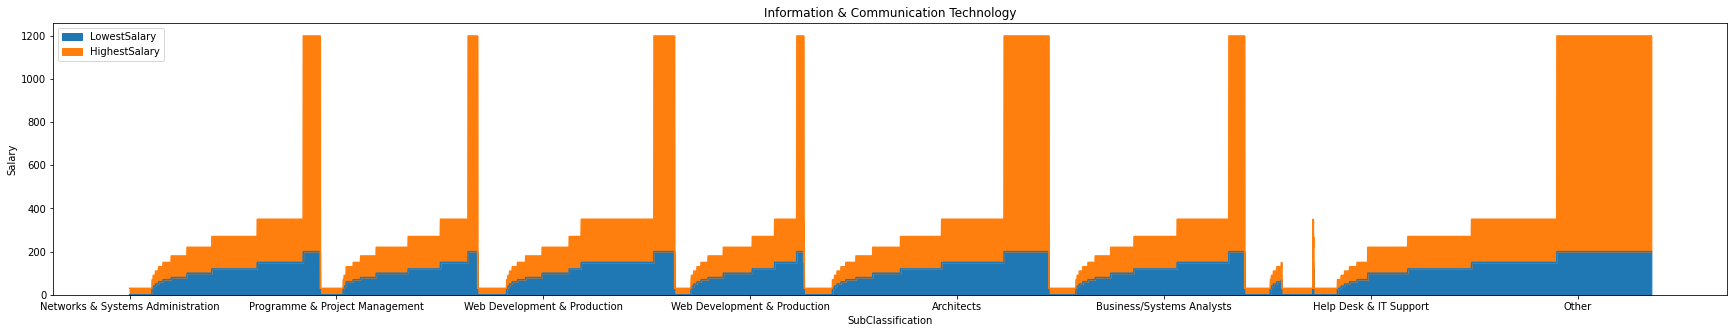

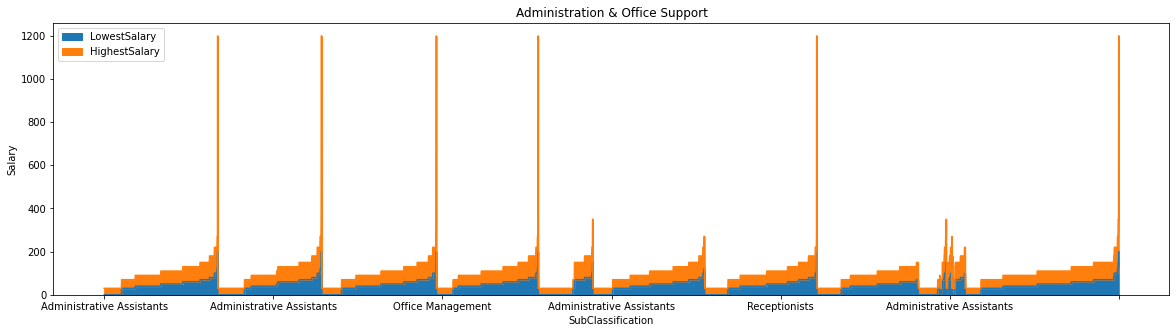

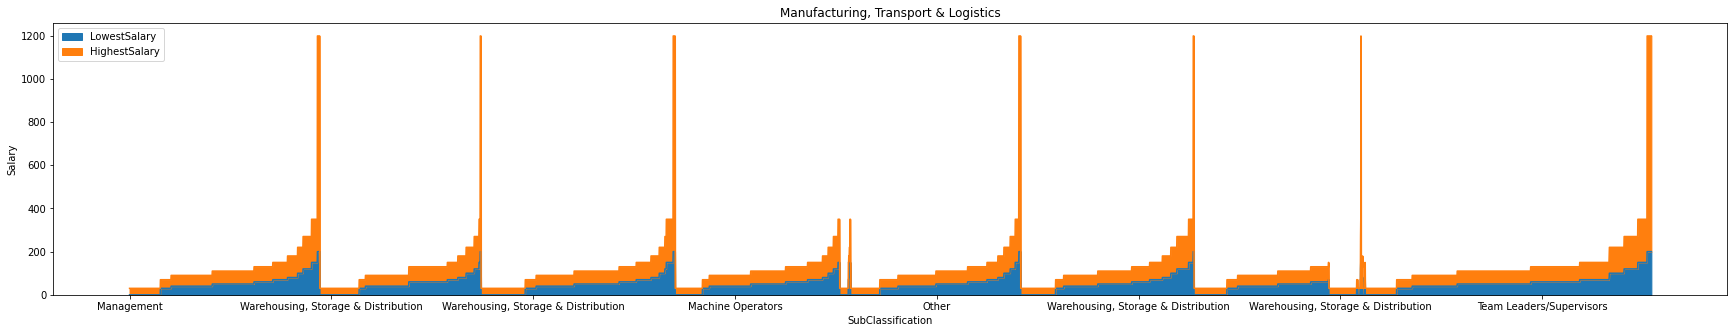

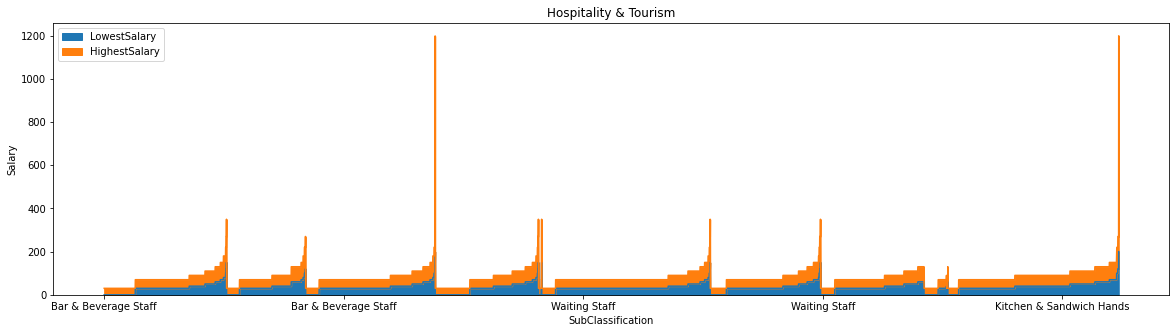

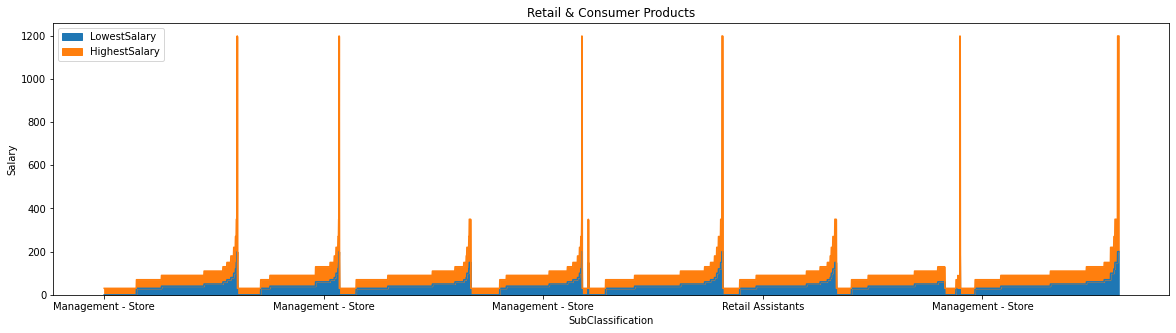

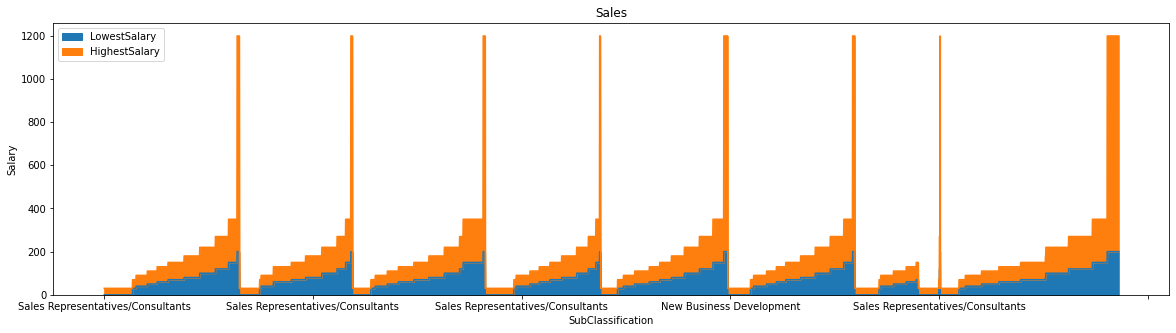

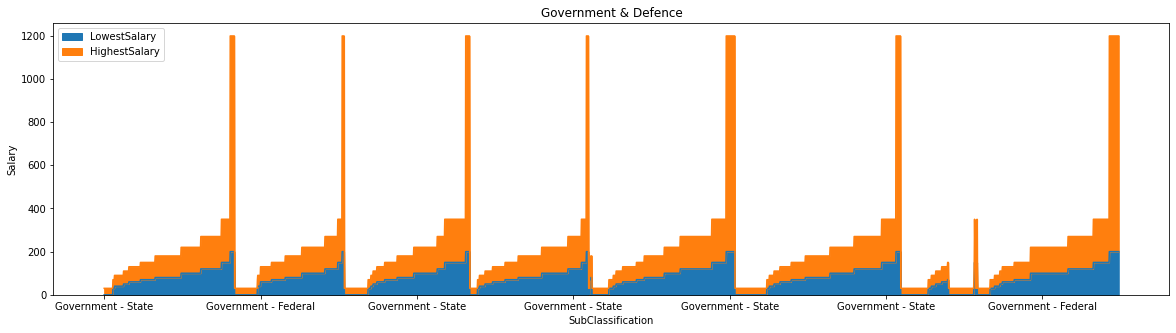

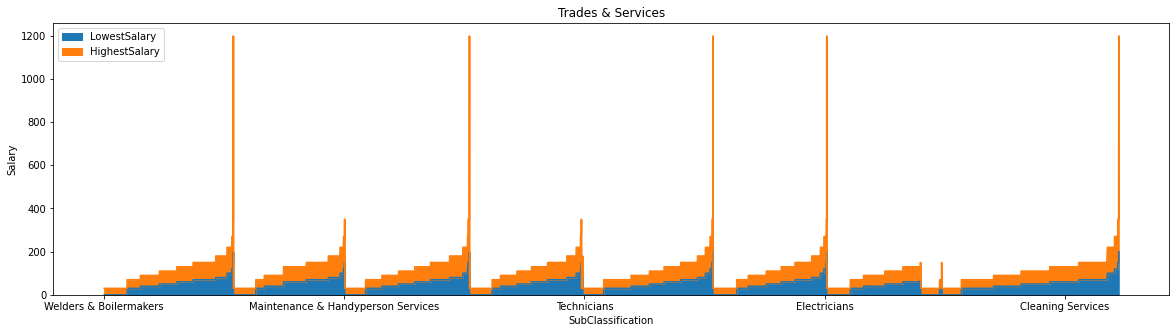

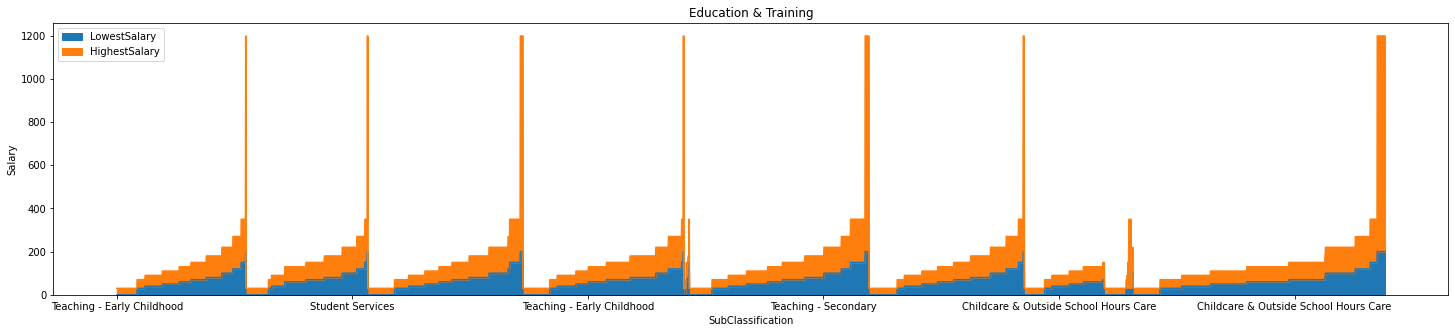

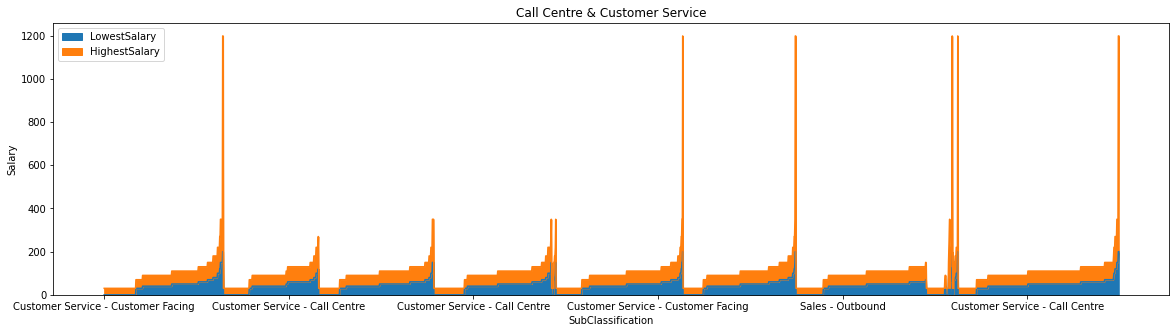

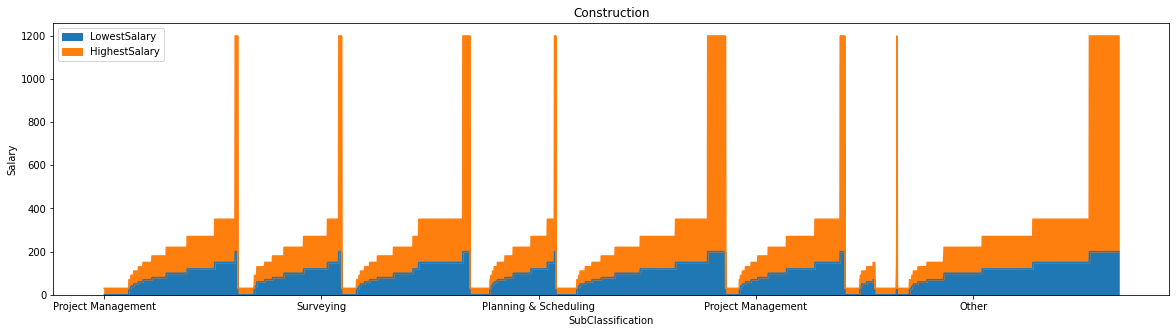

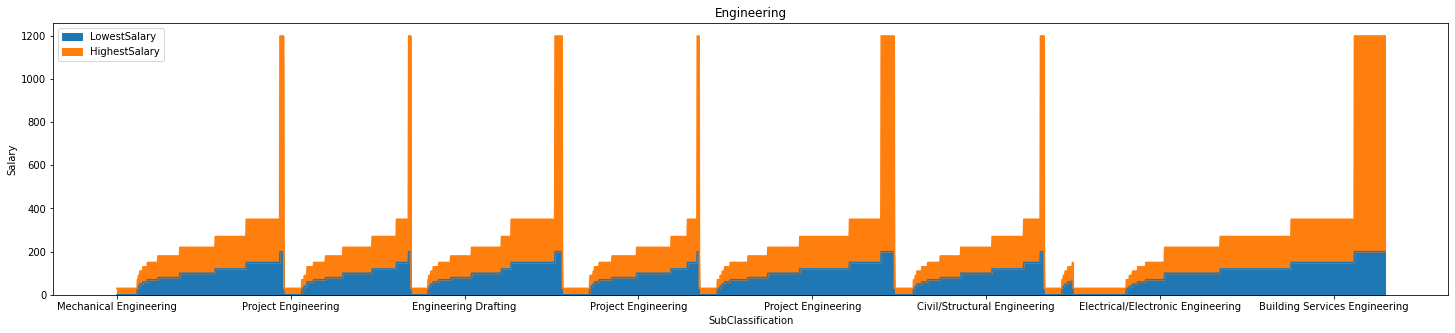

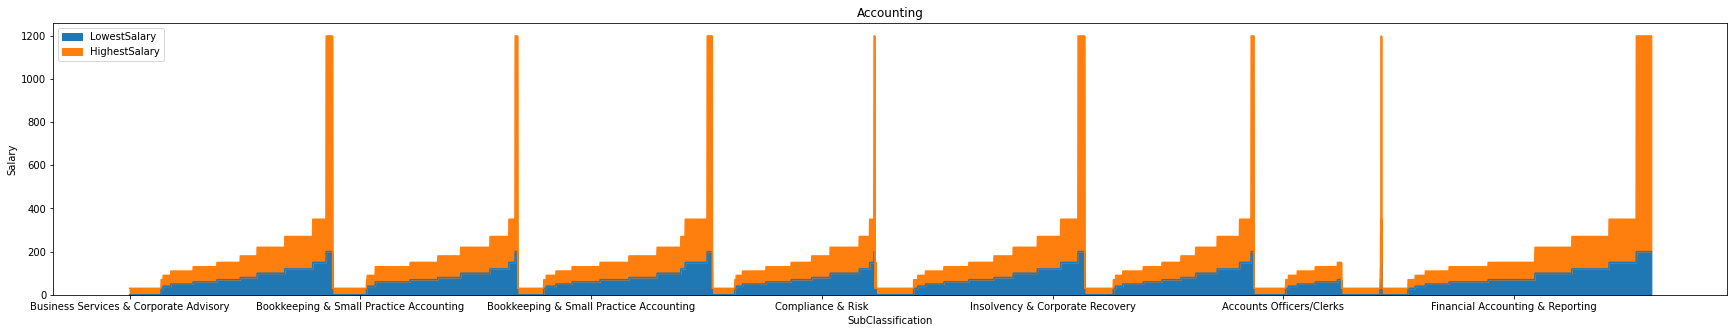

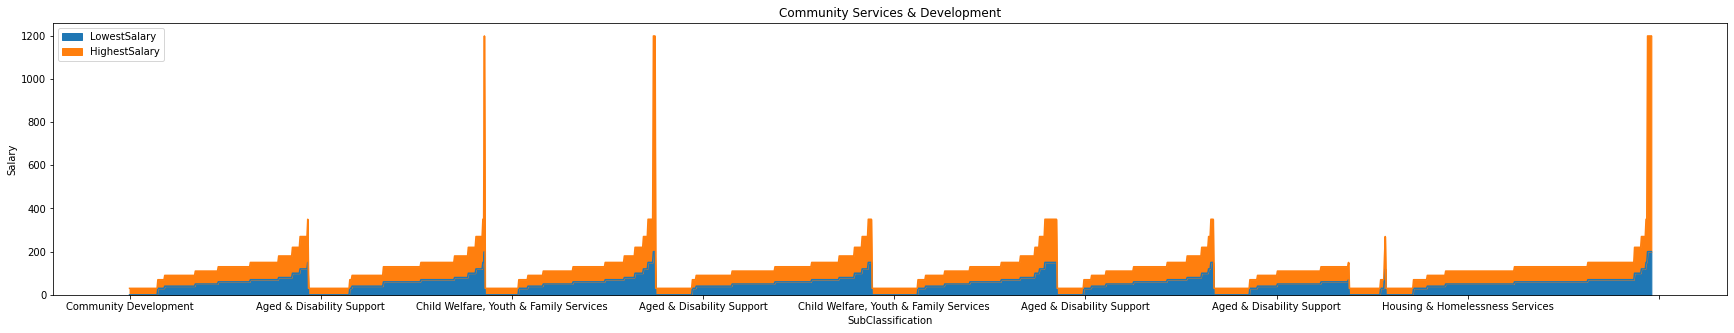

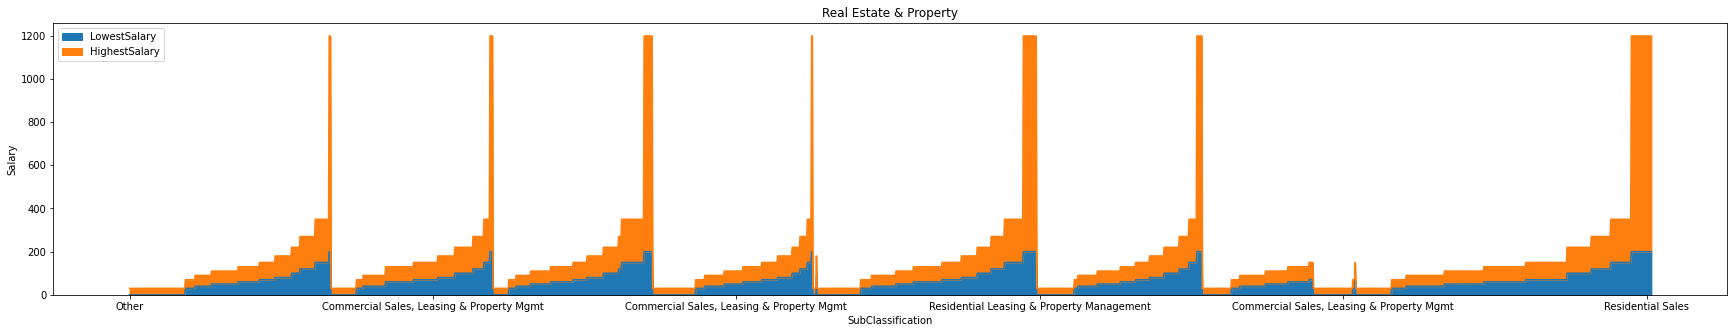

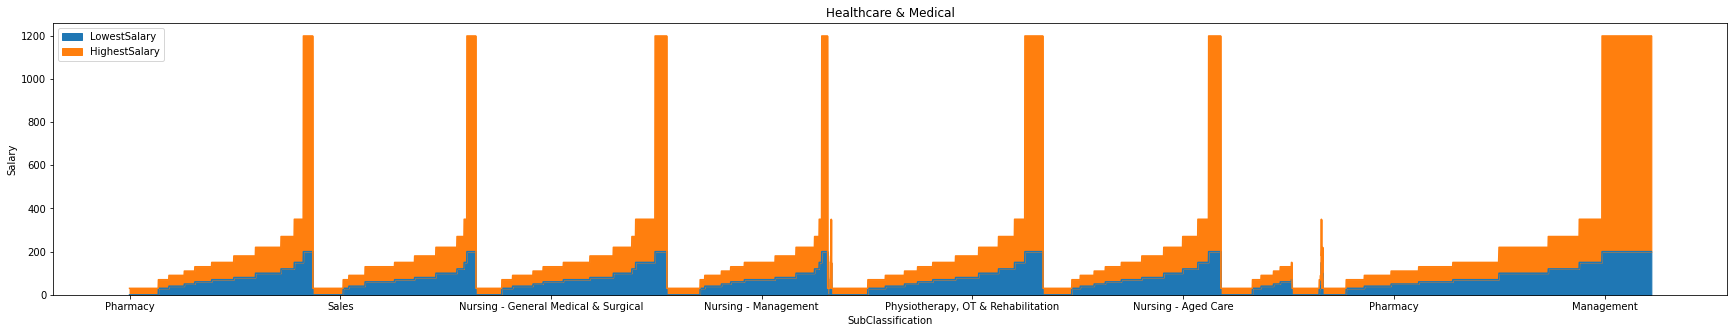

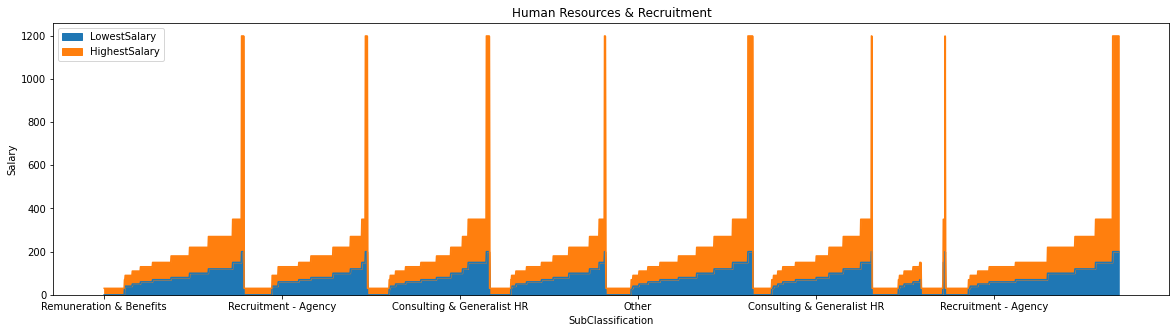

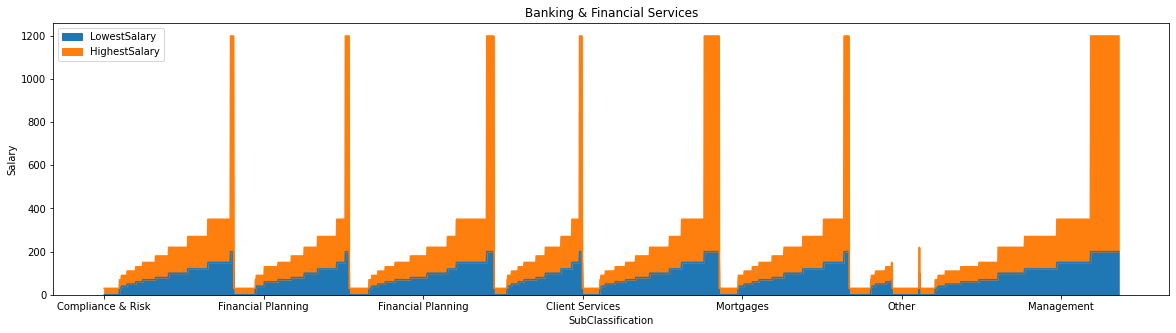

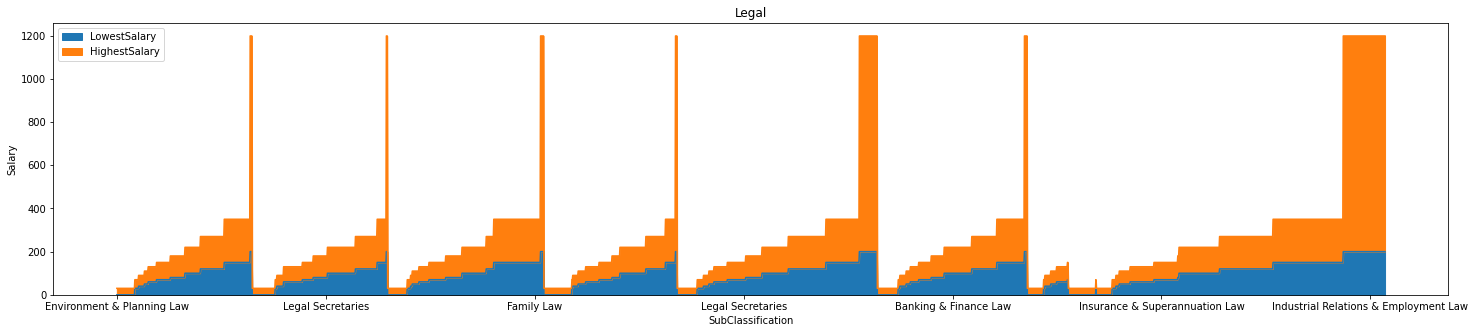

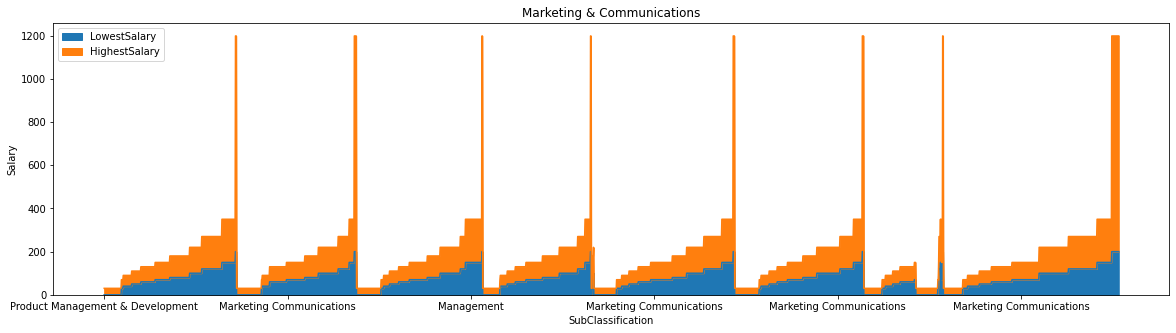

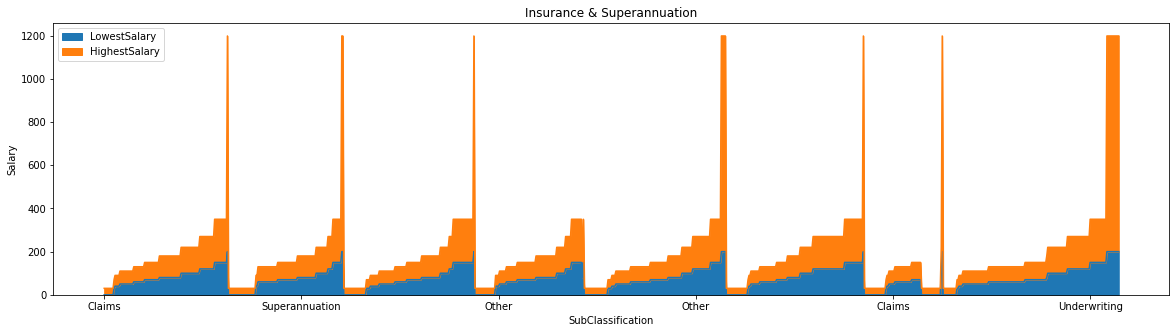

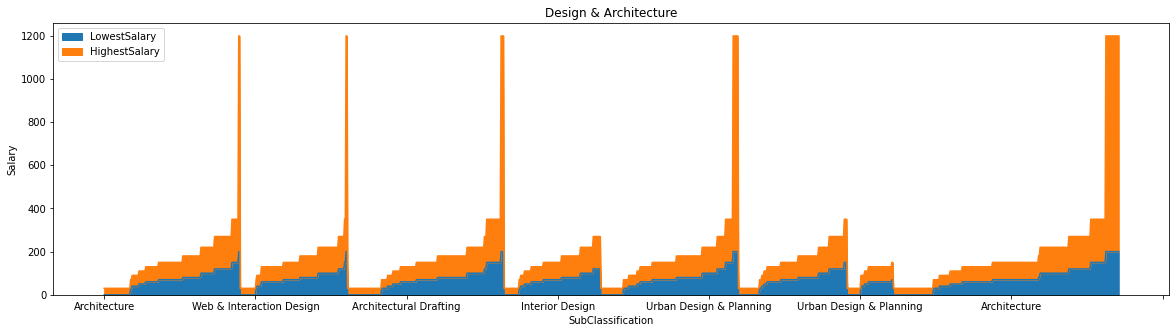

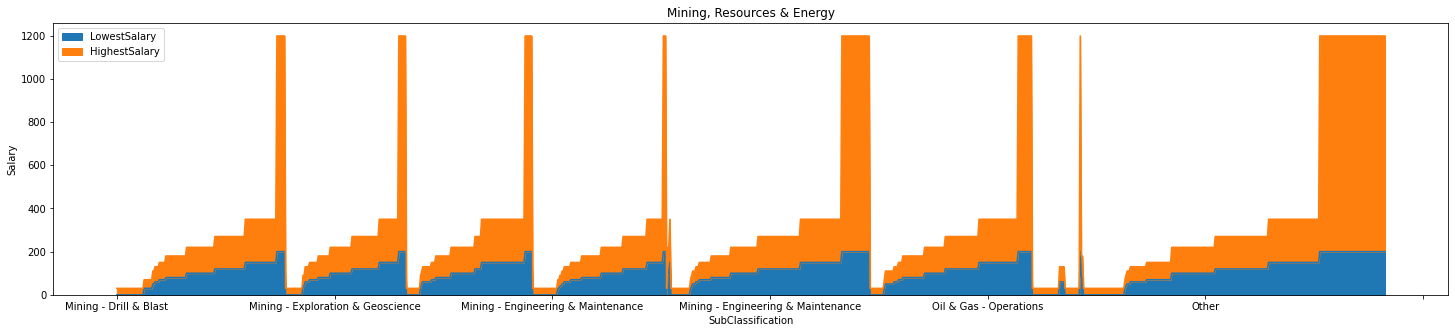

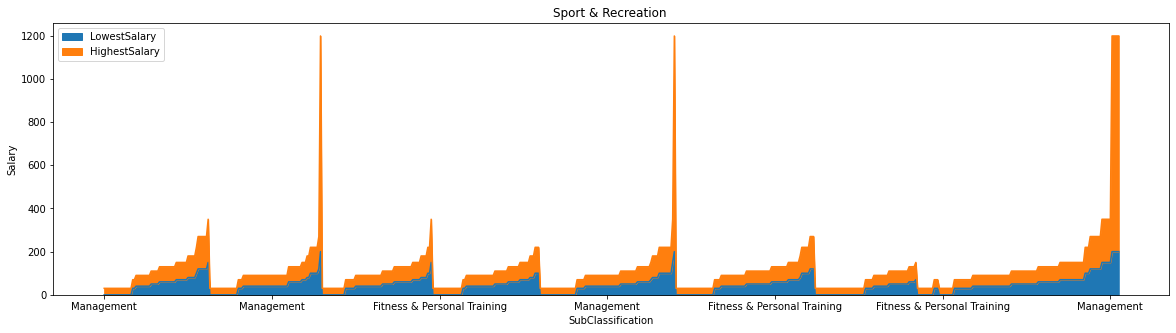

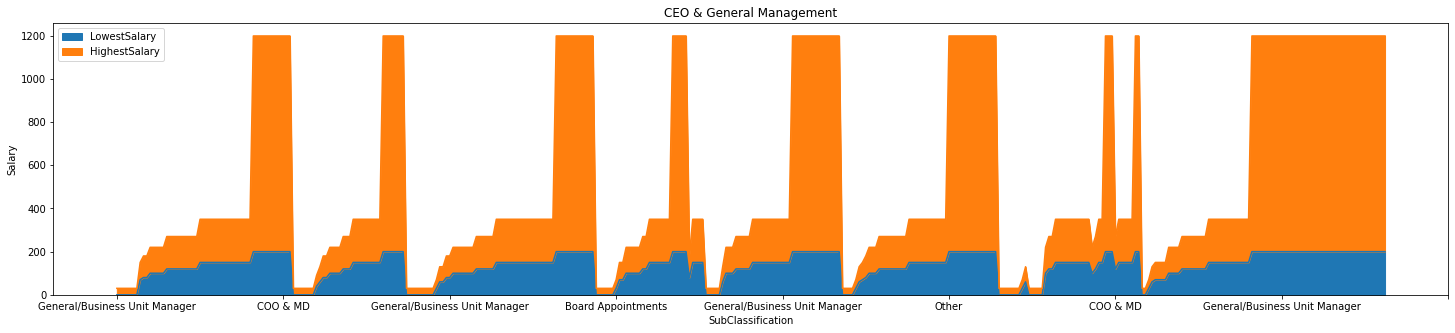

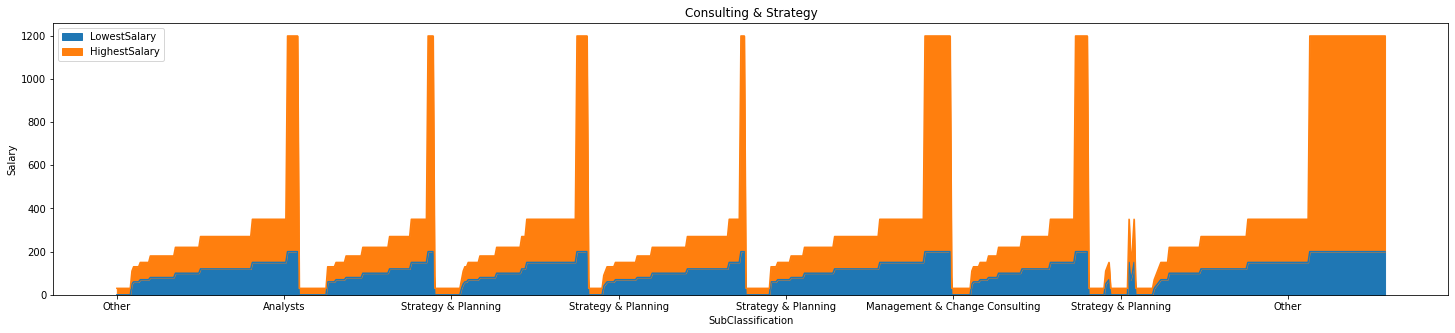

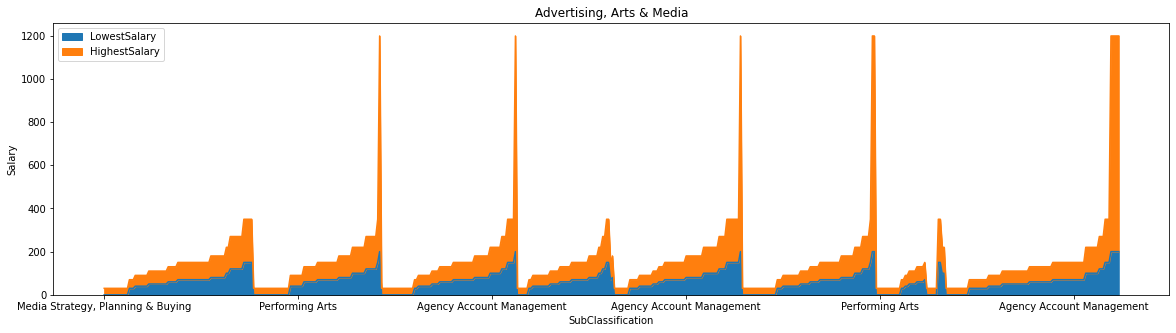

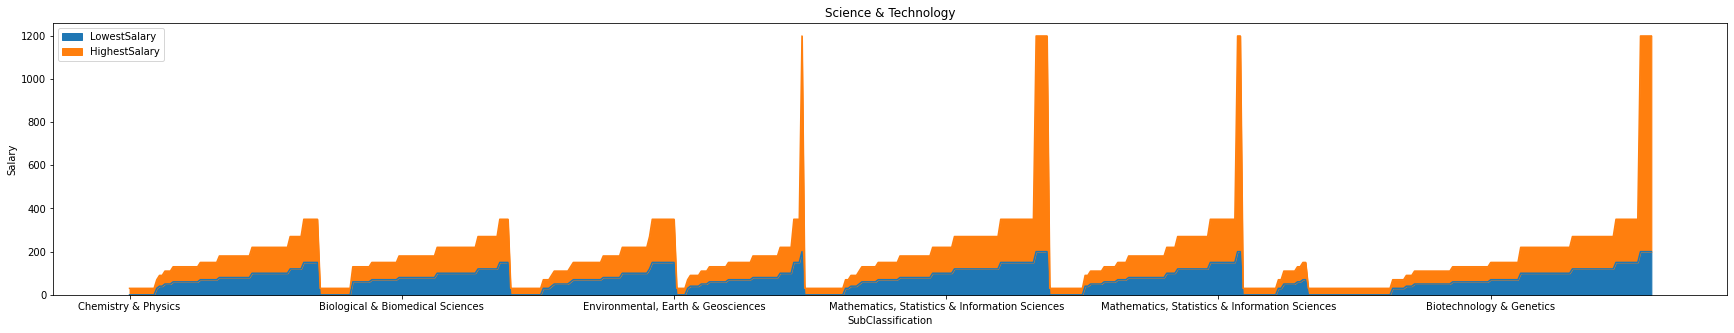

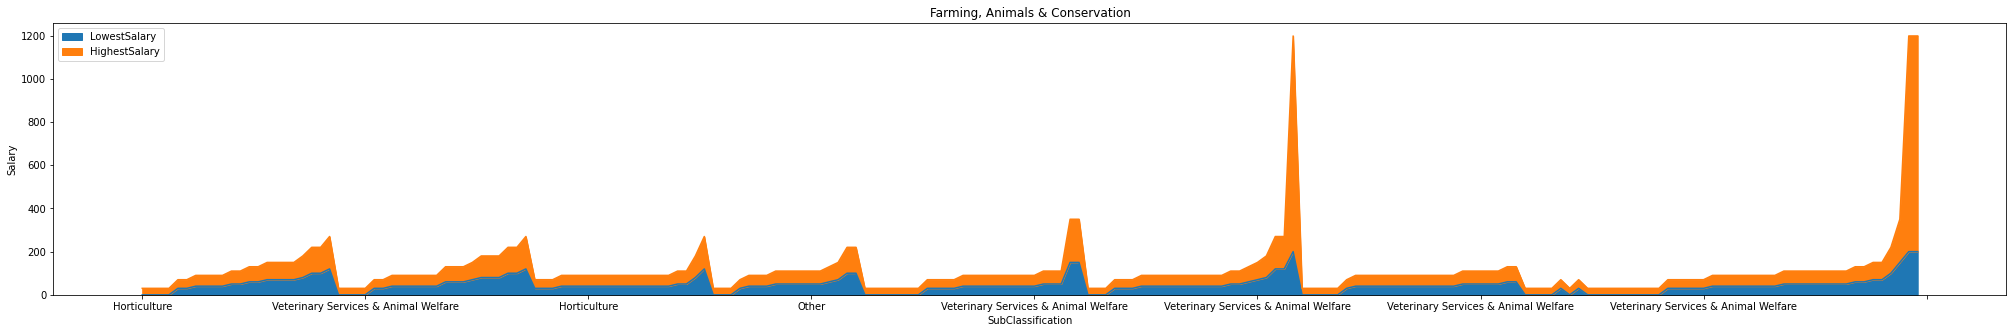

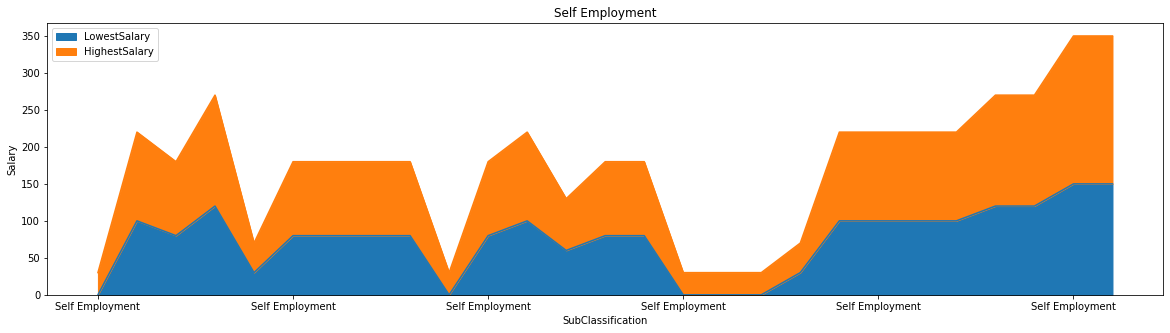

In [19]:
# Find the salary range distributions for each Sub Classification within every Classification
data13 = data[['Classification', 'SubClassification','LowestSalary','HighestSalary']].copy()

# All of the following code is to produce graphs of every pay range for every sub classification in every classification
data131 = data13.loc[data13['Classification'] == 'Information & Communication Technology']
data131 = data131.drop(columns='Classification')
data131.set_index('SubClassification').plot(figsize=(30,5), kind='area',title='Information & Communication Technology').set(ylabel='Salary')

data132 = data13.loc[data13['Classification'] == 'Administration & Office Support']
data132 = data132.drop(columns='Classification')
data132.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Administration & Office Support').set(ylabel='Salary')

data133 = data13.loc[data13['Classification'] == 'Manufacturing, Transport & Logistics']
data133 = data133.drop(columns='Classification')
data133.set_index('SubClassification').plot(figsize=(30,5), kind='area',title='Manufacturing, Transport & Logistics').set(ylabel='Salary')

data134 = data13.loc[data13['Classification'] == 'Hospitality & Tourism']
data134 = data134.drop(columns='Classification')
data134.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Hospitality & Tourism').set(ylabel='Salary')

data135 = data13.loc[data13['Classification'] == 'Retail & Consumer Products']
data135 = data135.drop(columns='Classification')
data135.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Retail & Consumer Products').set(ylabel='Salary')

data136 = data13.loc[data13['Classification'] == 'Sales']
data136 = data136.drop(columns='Classification')
data136.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Sales').set(ylabel='Salary')

data137 = data13.loc[data13['Classification'] == 'Government & Defence']
data137 = data137.drop(columns='Classification')
data137.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Government & Defence').set(ylabel='Salary')

data138 = data13.loc[data13['Classification'] == 'Trades & Services']
data138 = data138.drop(columns='Classification')
data138.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Trades & Services').set(ylabel='Salary')

data139 = data13.loc[data13['Classification'] == 'Education & Training']
data139 = data139.drop(columns='Classification')
data139.set_index('SubClassification').plot(figsize=(25,5), kind='area',title='Education & Training').set(ylabel='Salary')

data1310 = data13.loc[data13['Classification'] == 'Call Centre & Customer Service']
data1310 = data1310.drop(columns='Classification')
data1310.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Call Centre & Customer Service').set(ylabel='Salary')

data1311 = data13.loc[data13['Classification'] == 'Construction']
data1311 = data1311.drop(columns='Classification')
data1311.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Construction').set(ylabel='Salary')

data1312 = data13.loc[data13['Classification'] == 'Engineering']
data1312 = data1312.drop(columns='Classification')
data1312.set_index('SubClassification').plot(figsize=(25,5), kind='area',title='Engineering').set(ylabel='Salary')

data1313 = data13.loc[data13['Classification'] == 'Accounting']
data1313 = data1313.drop(columns='Classification')
data1313.set_index('SubClassification').plot(figsize=(30,5), kind='area',title='Accounting').set(ylabel='Salary')

data1314 = data13.loc[data13['Classification'] == 'Community Services & Development']
data1314 = data1314.drop(columns='Classification')
data1314.set_index('SubClassification').plot(figsize=(30,5), kind='area',title='Community Services & Development').set(ylabel='Salary')

data1315 = data13.loc[data13['Classification'] == 'Real Estate & Property']
data1315 = data1315.drop(columns='Classification')
data1315.set_index('SubClassification').plot(figsize=(30,5), kind='area',title='Real Estate & Property').set(ylabel='Salary')

data1316 = data13.loc[data13['Classification'] == 'Healthcare & Medical']
data1316 = data1316.drop(columns='Classification')
data1316.set_index('SubClassification').plot(figsize=(30,5), kind='area',title='Healthcare & Medical').set(ylabel='Salary')

data1317 = data13.loc[data13['Classification'] == 'Human Resources & Recruitment']
data1317 = data1317.drop(columns='Classification')
data1317.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Human Resources & Recruitment').set(ylabel='Salary')

data1318 = data13.loc[data13['Classification'] == 'Banking & Financial Services']
data1318 = data1318.drop(columns='Classification')
data1318.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Banking & Financial Services').set(ylabel='Salary')

data1319 = data13.loc[data13['Classification'] == 'Legal']
data1319 = data1319.drop(columns='Classification')
data1319.set_index('SubClassification').plot(figsize=(25,5), kind='area',title='Legal').set(ylabel='Salary')

data1320 = data13.loc[data13['Classification'] == 'Marketing & Communications']
data1320 = data1320.drop(columns='Classification')
data1320.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Marketing & Communications').set(ylabel='Salary')

data1321 = data13.loc[data13['Classification'] == 'Insurance & Superannuation']
data1321 = data1321.drop(columns='Classification')
data1321.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Insurance & Superannuation').set(ylabel='Salary')

data1322 = data13.loc[data13['Classification'] == 'Design & Architecture']
data1322 = data1322.drop(columns='Classification')
data1322.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Design & Architecture').set(ylabel='Salary')

data1323 = data13.loc[data13['Classification'] == 'Mining, Resources & Energy']
data1323 = data1323.drop(columns='Classification')
data1323.set_index('SubClassification').plot(figsize=(25,5), kind='area',title='Mining, Resources & Energy').set(ylabel='Salary')

data1324 = data13.loc[data13['Classification'] == 'Sport & Recreation']
data1324 = data1324.drop(columns='Classification')
data1324.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Sport & Recreation ').set(ylabel='Salary')

data1325 = data13.loc[data13['Classification'] == 'CEO & General Management']
data1325 = data1325.drop(columns='Classification')
data1325.set_index('SubClassification').plot(figsize=(25,5), kind='area',title='CEO & General Management').set(ylabel='Salary')

data1326 = data13.loc[data13['Classification'] == 'Consulting & Strategy']
data1326 = data1326.drop(columns='Classification')
data1326.set_index('SubClassification').plot(figsize=(25,5), kind='area',title='Consulting & Strategy').set(ylabel='Salary')

data1327 = data13.loc[data13['Classification'] == 'Advertising, Arts & Media']
data1327 = data1327.drop(columns='Classification')
data1327.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Advertising, Arts & Media').set(ylabel='Salary')

data1328 = data13.loc[data13['Classification'] == 'Science & Technology']
data1328 = data1328.drop(columns='Classification')
data1328.set_index('SubClassification').plot(figsize=(30,5), kind='area',title='Science & Technology').set(ylabel='Salary')

data1329 = data13.loc[data13['Classification'] == 'Farming, Animals & Conservation']
data1329 = data1329.drop(columns='Classification')
data1329.set_index('SubClassification').plot(figsize=(35,5), kind='area',title='Farming, Animals & Conservation').set(ylabel='Salary')

data1330 = data13.loc[data13['Classification'] == 'Self Employment']
data1330 = data1330.drop(columns='Classification')
data1330.set_index('SubClassification').plot(figsize=(20,5), kind='area',title='Self Employment').set(ylabel='Salary')



Data distribution:
 0    4779
1    2745
3     921
2       5
Name: kmean, dtype: int64
Trades & Services Cluster locations
[[ 54.90688429  64.90688429]
 [ 12.08743169  34.0291439 ]
 [200.         999.        ]
 [ 92.62757872 114.80998914]]


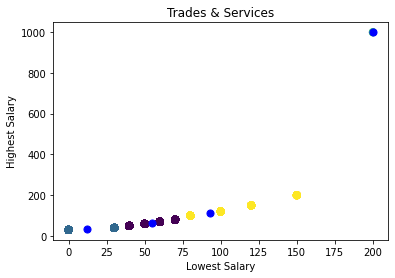

Data distribution:
 0    2388
2    1928
3    1000
1      69
Name: kmean, dtype: int64
Education & Training Cluster locations
[[ 64.69430486  76.82160804]
 [200.         999.        ]
 [ 18.69813278  38.3973029 ]
 [115.66       144.48      ]]


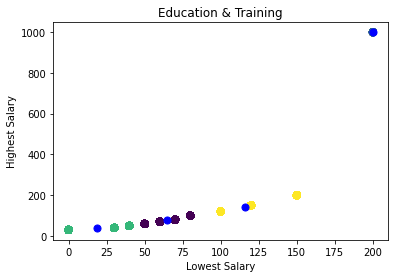

Data distribution:
 3    1481
0    1279
2     705
1     183
Name: kmean, dtype: int64
Engineering Cluster locations
[[134.23768569 173.72947615]
 [200.         999.        ]
 [  9.14893617  34.75177305]
 [ 85.99594868 103.24105334]]


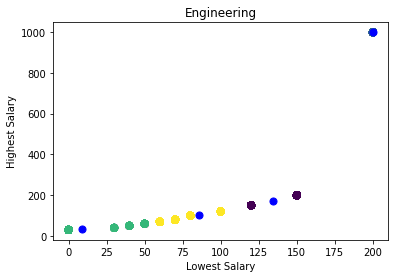

Data distribution:
 0    5987
3    3562
2    3142
1    2022
Name: kmean, dtype: int64
Information & Communication Technology Cluster locations
[[102.45364957 125.70068482]
 [200.         999.        ]
 [ 15.08593253  39.06429026]
 [150.         200.        ]]


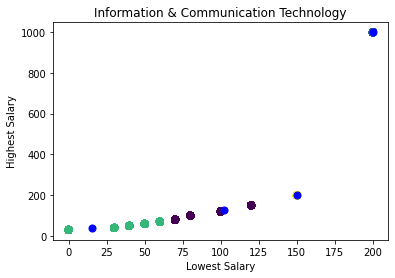

Data distribution:
 0    1263
2     879
3     582
1      43
Name: kmean, dtype: int64
Marketing & Communications Cluster locations
[[ 62.81076801  74.80601742]
 [200.         999.        ]
 [118.36177474 148.7258248 ]
 [  2.98969072  30.99656357]]


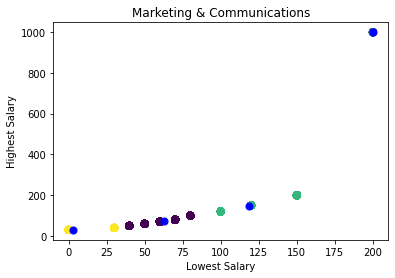

Data distribution:
 1    112
0    109
3     96
2     65
Name: kmean, dtype: int64
CEO & General Management Cluster locations
[[150.         200.        ]
 [200.         999.        ]
 [  9.38461538  35.38461538]
 [105.625      129.6875    ]]


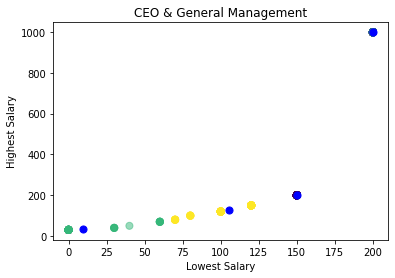

Data distribution:
 0    1530
3     734
2     528
1      60
Name: kmean, dtype: int64
Human Resources & Recruitment Cluster locations
[[ 74.39215686  88.61437908]
 [200.         999.        ]
 [132.84090909 171.40151515]
 [  7.98365123  33.8147139 ]]


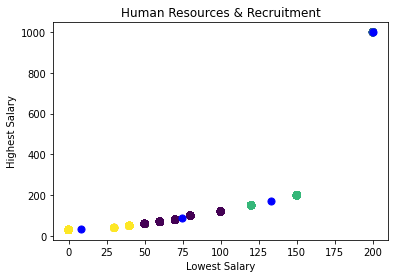

Data distribution:
 0    3211
3    1906
2    1305
1     173
Name: kmean, dtype: int64
Accounting Cluster locations
[[ 62.20803488  73.83681096]
 [200.         999.        ]
 [  2.34482759  30.7816092 ]
 [118.25288562 148.54669465]]


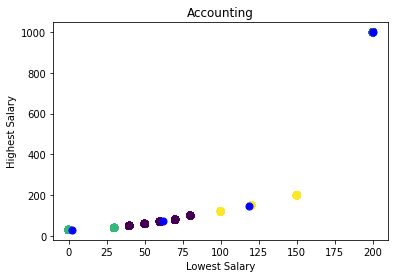

Data distribution:
 3    1274
0     986
2     605
1     171
Name: kmean, dtype: int64
Legal Cluster locations
[[136.2474645  177.07910751]
 [200.         999.        ]
 [  9.14049587  34.11570248]
 [ 78.50863422  93.61067504]]


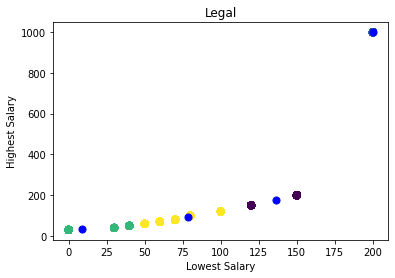

Data distribution:
 0    1302
3     663
2     455
1      89
Name: kmean, dtype: int64
Real Estate & Property Cluster locations
[[ 57.61136713  68.8172043 ]
 [200.         999.        ]
 [122.74725275 155.82417582]
 [  5.42986425  31.80995475]]


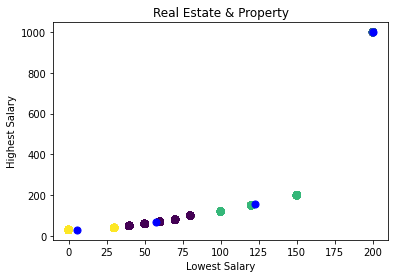

Data distribution:
 2    4820
0    1986
3     674
1      62
Name: kmean, dtype: int64
Manufacturing, Transport & Logistics Cluster locations
[[  6.67673716  32.22557905]
 [200.         999.        ]
 [ 52.47925311  62.97095436]
 [119.82195846 150.97922849]]


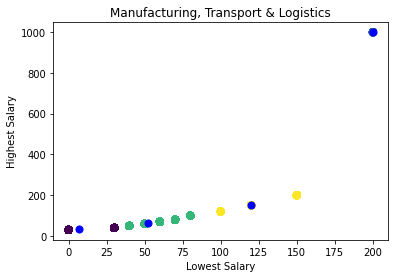

Data distribution:
 3    2699
0    2353
2    1620
1     551
Name: kmean, dtype: int64
Healthcare & Medical Cluster locations
[[ 16.59158521  37.42881428]
 [200.         999.        ]
 [116.75308642 146.27160494]
 [ 66.48017784  78.829196  ]]


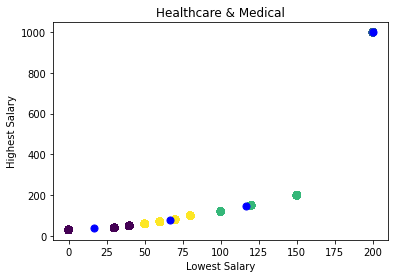

Data distribution:
 1    1416
2     848
3     712
0     205
Name: kmean, dtype: int64
Banking & Financial Services Cluster locations
[[200.         999.        ]
 [ 75.96045198  90.64265537]
 [136.23820755 177.06367925]
 [  9.49438202  34.49438202]]


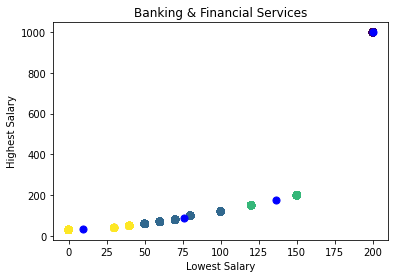

Data distribution:
 2    1771
0    1737
3     857
1     306
Name: kmean, dtype: int64
Construction Cluster locations
[[ 81.87104203  98.08290155]
 [200.         999.        ]
 [135.34726143 175.57876906]
 [  4.99416569  32.19369895]]


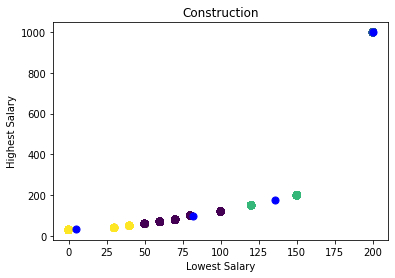

Data distribution:
 0    367
3    160
2     72
1      7
Name: kmean, dtype: int64
Sport & Recreation Cluster locations
[[4.84196185e+01 5.84196185e+01]
 [2.00000000e+02 9.99000000e+02]
 [1.05694444e+02 1.31805556e+02]
 [2.84217094e-14 3.00000000e+01]]


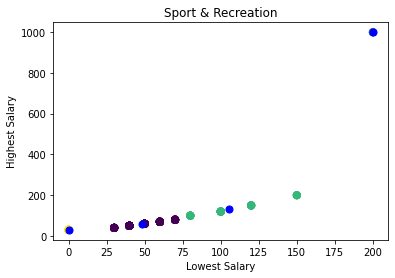

Data distribution:
 2    1657
3     759
0     714
1     115
Name: kmean, dtype: int64
Government & Defence Cluster locations
[[131.34453782 168.90756303]
 [200.         999.        ]
 [ 79.28786964  95.07543754]
 [  8.90645586  34.00527009]]


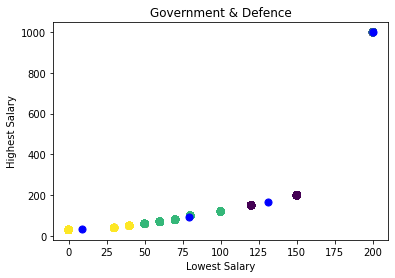

Data distribution:
 1    5433
0    1659
3    1377
2       2
Name: kmean, dtype: int64
Hospitality & Tourism Cluster locations
[[5.97287523e+01 7.08318264e+01]
 [3.28510952e+01 4.28510952e+01]
 [2.00000000e+02 9.99000000e+02]
 [1.42108547e-14 3.00000000e+01]]


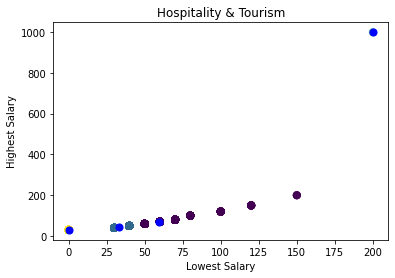

Data distribution:
 3    2370
0    1280
2    1092
1     120
Name: kmean, dtype: int64
Sales Cluster locations
[[119.828125   151.09375   ]
 [200.         999.        ]
 [  3.81868132  31.27289377]
 [ 60.02109705  71.84810127]]


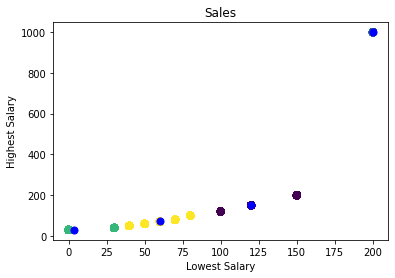

Data distribution:
 3    3584
0     837
2     187
1      14
Name: kmean, dtype: int64
Retail & Consumer Products Cluster locations
[[-4.26325641e-14  3.00000000e+01]
 [ 2.00000000e+02  9.99000000e+02]
 [ 1.09518717e+02  1.37914439e+02]
 [ 4.27957589e+01  5.27957589e+01]]


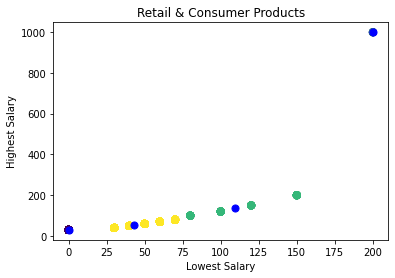

Data distribution:
 0    1997
2     613
3     130
1       9
Name: kmean, dtype: int64
Call Centre & Customer Service Cluster locations
[[ 47.79168753  57.79168753]
 [200.         999.        ]
 [  0.          30.        ]
 [101.69230769 127.38461538]]


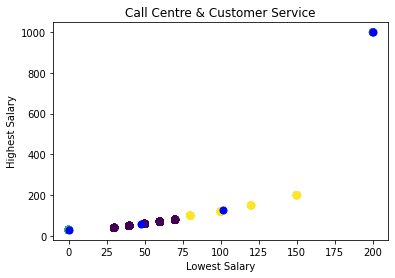

Data distribution:
 3    2844
1    1832
0    1315
2       9
Name: kmean, dtype: int64
Administration & Office Support Cluster locations
[[-4.97379915e-14  3.00000000e+01]
 [ 7.01855895e+01  8.27729258e+01]
 [ 2.00000000e+02  9.99000000e+02]
 [ 4.13009845e+01  5.13009845e+01]]


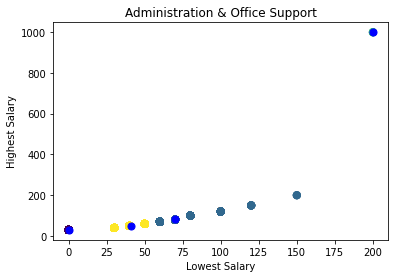

Data distribution:
 0    704
2    325
3    281
1     33
Name: kmean, dtype: int64
Design & Architecture Cluster locations
[[ 65.63920455  78.125     ]
 [200.         999.        ]
 [116.24615385 145.35384615]
 [  3.30960854  31.10320285]]


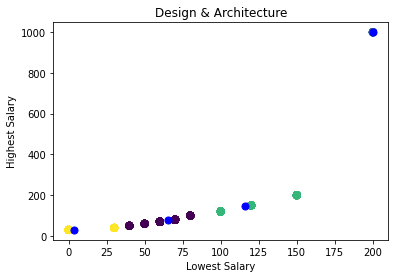

Data distribution:
 2    424
0    410
3    206
1    126
Name: kmean, dtype: int64
Mining, Resources & Energy Cluster locations
[[ 83.09756098  99.82926829]
 [200.         999.        ]
 [135.8490566  176.41509434]
 [  3.25242718  31.31067961]]


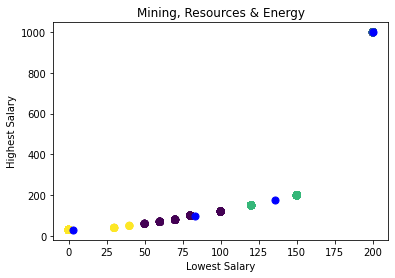

Data distribution:
 3    258
0    176
2    113
1     13
Name: kmean, dtype: int64
Science & Technology Cluster locations
[[ 16.30681818  38.80681818]
 [200.         999.        ]
 [134.33628319 173.89380531]
 [ 79.37984496  94.96124031]]


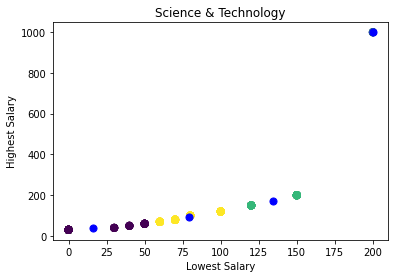

Data distribution:
 3    228
0    194
2     92
1     10
Name: kmean, dtype: int64
Advertising, Arts & Media Cluster locations
[[ 15.51546392  37.06185567]
 [200.         999.        ]
 [119.89130435 151.19565217]
 [ 65.87719298  77.85087719]]


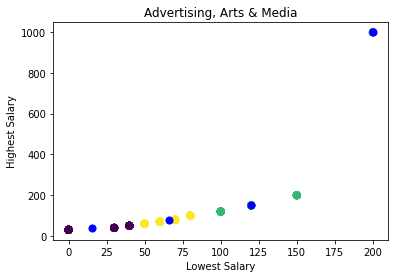

Data distribution:
 2    572
0    229
3    205
1     24
Name: kmean, dtype: int64
Insurance & Superannuation Cluster locations
[[  7.29257642  33.36244541]
 [200.         999.        ]
 [ 71.06643357  84.63286713]
 [134.92682927 174.87804878]]


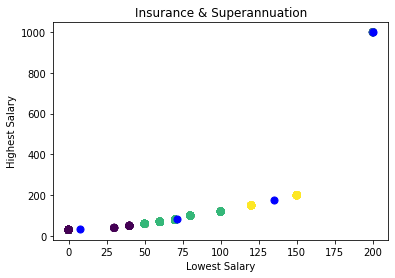

Data distribution:
 2    113
0     63
3     21
1      3
Name: kmean, dtype: int64
Farming, Animals & Conservation Cluster locations
[[ 10.95238095  33.65079365]
 [200.         999.        ]
 [ 46.81415929  56.81415929]
 [106.19047619 132.85714286]]


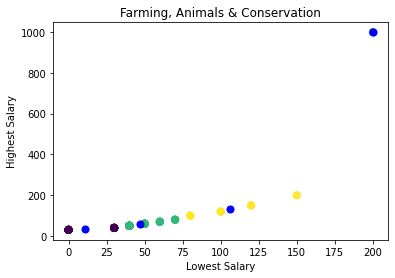

Data distribution:
 0    1345
2     484
3     152
1      10
Name: kmean, dtype: int64
Community Services & Development Cluster locations
[[ 57.38289963  68.19330855]
 [200.         999.        ]
 [  5.08264463  31.69421488]
 [118.75       149.34210526]]


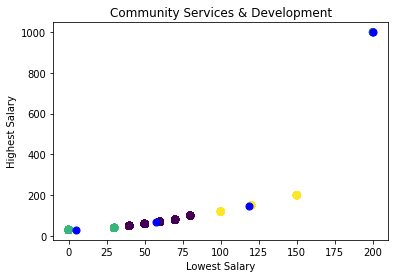

Data distribution:
 0    9
3    9
1    7
2    2
Name: kmean, dtype: int64
Self Employment Cluster locations
[[ 77.77777778  96.66666667]
 [  8.57142857  32.85714286]
 [150.         200.        ]
 [106.66666667 130.        ]]


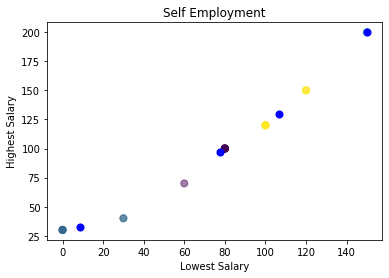

Data distribution:
 0    293
3    261
2    114
1     91
Name: kmean, dtype: int64
Consulting & Strategy Cluster locations
[[135.2559727  175.42662116]
 [200.         999.        ]
 [  1.22807018  30.52631579]
 [ 84.44444444 101.22605364]]


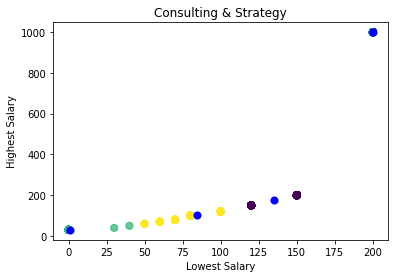

In [20]:
# Question 4: Visualize the data
# Using statistical analysis apply Kmeans clustering to all classifications to find salary distribution
# Extract data of the classifications and their salary ranges
data14 = data[['Classification','LowestSalary','HighestSalary']].copy()
# Create a seperate list which contains the classification names only
data14l = data14['Classification'].unique()

# Iterate through every classification and produce the cluster's and plot each point by lowest and highest salary
for i in data14l:
    # All of the following code is to produce scatter plots
    # Each of these shows the clustering of every salary and the appropriate cluster to determine the salary distribution
    # Filter data for selected Classification
    data141 = data14.loc[data14['Classification'] == i]
    data141 = data141.drop(columns='Classification')
    # Apply k means to the data and extract the appropriate cluster centers - 4 clusters have been defined
    km = KMeans(n_clusters=4).fit(data141)
    kcenters = km.cluster_centers_
    data141['kmean'] = km.labels_
    print("Data distribution:\n",data141['kmean'].value_counts())
    print (i, "Cluster locations")
    print(kcenters)
    # Place the data on the scatter plot and color based closest center.
    plt.scatter(data141['LowestSalary'], data141['HighestSalary'], c= km.labels_.astype(float), s=50, alpha=0.5)
    plt.scatter(kcenters[:, 0], kcenters[:, 1], c='blue', s=50)
    plt.title(i)
    plt.xlabel('Lowest Salary')
    plt.ylabel('Highest Salary')
    plt.show()


<AxesSubplot:xlabel='Date'>

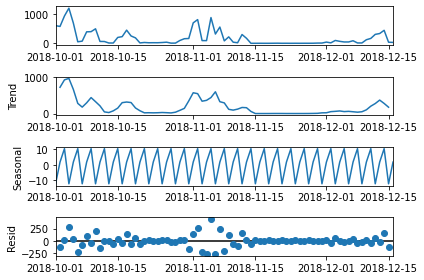

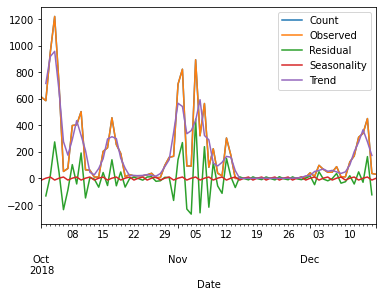

In [21]:
# Based on posting pattern - Use the predictive analysis - apply predictive forecasting to get current seasonality and trend

# create a function to set and sort the date index for calculating seasonality
def date_index(df_input, variable='Date'):
    # Copy original dataset
    df = df_input.copy()
    
    # Change the data type of the variable/column to datetime if not done already
    df[variable] = pd.to_datetime(df[variable])
    
    # Sort values and index according to their value and index
    df.sort_values(variable, inplace=True)
    df.set_index(variable, inplace=True)
    
    # Returned converted, indexed, and sorted data
    return df

# Function to combine the seasonal decomposition and data -> returns the observed, residual, seasonality, and trend of data
def combine_sd_ts(df, season_df):
    df['Observed'] = season_df.observed
    df['Residual'] = season_df.resid
    df['Seasonality'] = season_df.seasonal
    df['Trend'] = season_df.trend

# Load data and convert to date time
data15 = data[['Date']].copy()
data15['Date'] = pd.to_datetime(data15['Date'])

# Create time series version fo the data
data15ts = data15.groupby(['Date']).size().reset_index().rename(columns={0:'Count'}).sort_values(by=['Date'], ascending=True)

# Normalize count as the different months have different days
data15ts['Count'] = data15ts['Count'] / pd.to_datetime(data15ts['Date']).dt.day

# Index the data
data15ts = date_index(data15ts, 'Date')

# Get seasonal decomposition
data15sd = seasonal_decompose(data15ts, period = 3)
# Plot the seasonal decomposition showing trend, seasonality and residual individually
data15sd.plot()

# Combine all displays of the data into one dataset
combine_sd_ts(data15ts, data15sd)
# Display final plot
data15ts.plot()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1193.474, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1173.518, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1191.630, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1176.784, Time=0.01 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1166.118, Time=0.53 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1162.698, Time=1.19 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=0.85 s

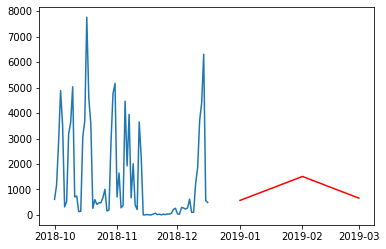

In [22]:
# Based on what has been gathered from currently existing data try to estimate the next 3 months job postings
data16 = data15.groupby(['Date']).size().reset_index().rename(columns={0:'Count'}).sort_values(by=['Date'], ascending=True)
# Set date column at the index and set index for each row
data16 = data16.set_index('Date')
data16.index

# Calculate seasonal fit to best match the data using arima for time series model forecasting
data16model = pm.auto_arima(data16, start_p=1, start_q= 1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=None, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
# Print best ARIMA inputs: p(number of lag observations), d(Degree of differencing), and q(Size of the moving window) inputs 
# These are for the model which best fit the data set and can be used for the time series forecasting
print(data16model.aic())

# Predict data for the next month forecasts
months = 3
# Find fit and conf from the model prediction using results of arima
fit, conf = data16model.predict(n_periods=months, return_conf_int=True)
# Calculate forecase index from the range of dates in the data by months
forecast_index = pd.date_range(data16.index[-1], periods = months, freq='MS')
# Calculate the diferent time series from the predictions
fit_series = pd.Series(fit, index=forecast_index)
low_series = pd.Series(conf[:,0], index=forecast_index)
high_series = pd.Series(conf[:, 1], index=forecast_index)
# Plot all the data with the prediction and the "range" of possible outcomes (shown in grey)
plt.plot(data16)
plt.plot(fit_series, color='red')
plt.show()

Data distribution:
 3    292
0    279
2    134
1     43
Name: kmean, dtype: int64
Total data points: 748
Networks & Systems Administration Cluster locations
[[136.77419355 177.95698925]
 [200.         999.        ]
 [  2.23880597  31.04477612]
 [ 82.97945205  99.69178082]]


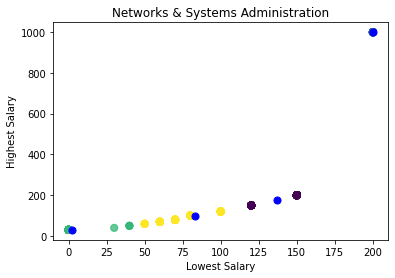

Data distribution:
 3    448
2    415
1    397
0    220
Name: kmean, dtype: int64
Total data points: 1480
Programme & Project Management Cluster locations
[[  4.72727273  32.72727273]
 [200.         999.        ]
 [106.74698795 131.68674699]
 [150.         200.        ]]


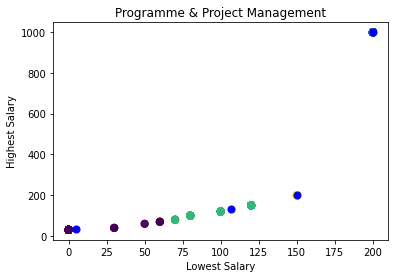

Data distribution:
 1    606
2    237
3     93
0      4
Name: kmean, dtype: int64
Total data points: 940
Help Desk & IT Support Cluster locations
[[200.         999.        ]
 [ 58.31683168  69.19141914]
 [  3.79746835  31.26582278]
 [114.19354839 142.25806452]]


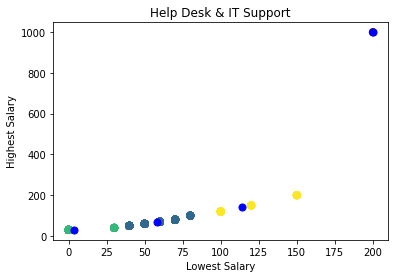

Data distribution:
 0    103
3    102
2     75
1     47
Name: kmean, dtype: int64
Total data points: 327
Sales - Pre & Post Cluster locations
[[ 32.03883495  49.80582524]
 [200.         999.        ]
 [150.         200.        ]
 [105.88235294 130.19607843]]


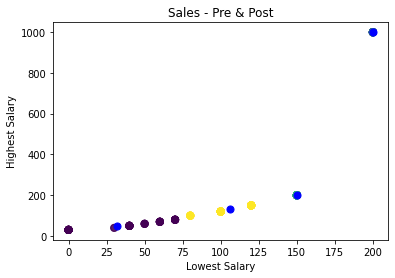

Data distribution:
 3    196
0    156
1     72
2     70
Name: kmean, dtype: int64
Total data points: 494
Security Cluster locations
[[150.         200.        ]
 [200.         999.        ]
 [  4.          32.28571429]
 [104.59183673 128.36734694]]


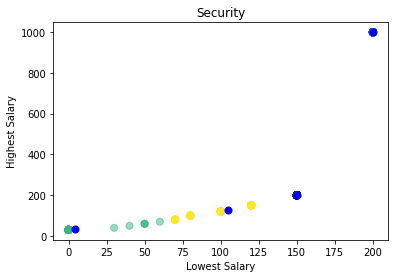

Data distribution:
 1    294
3    187
2    131
0    122
Name: kmean, dtype: int64
Total data points: 734
Consultants Cluster locations
[[200.         999.        ]
 [105.30612245 129.48979592]
 [  4.88549618  32.90076336]
 [150.         200.        ]]


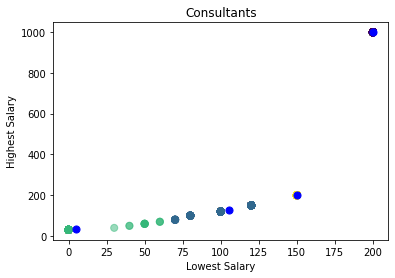

Data distribution:
 1    345
0    331
3    191
2    117
Name: kmean, dtype: int64
Total data points: 984
Architects Cluster locations
[[200.         999.        ]
 [150.         200.        ]
 [  1.36752137  30.51282051]
 [112.67015707 139.7382199 ]]


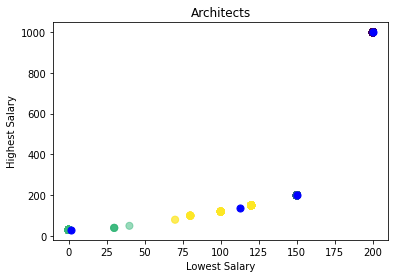

Data distribution:
 0    676
3    552
2    328
1    322
Name: kmean, dtype: int64
Total data points: 1878
Business/Systems Analysts Cluster locations
[[101.65680473 124.71893491]
 [200.         999.        ]
 [  8.04878049  35.        ]
 [150.         200.        ]]


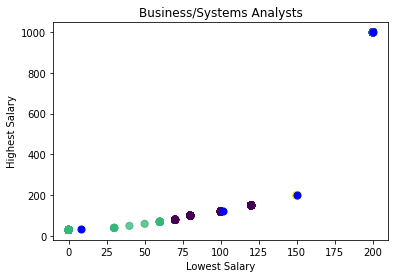

Data distribution:
 2    1424
3     628
0     541
1     276
Name: kmean, dtype: int64
Total data points: 2869
Developers/Programmers Cluster locations
[[  9.31608133  35.54528651]
 [200.         999.        ]
 [103.00561798 126.48174157]
 [150.         200.        ]]


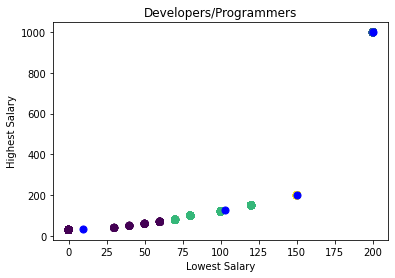

Data distribution:
 0    131
3     90
2     76
1     15
Name: kmean, dtype: int64
Total data points: 312
Web Development & Production Cluster locations
[[ 86.48854962 103.74045802]
 [200.         999.        ]
 [  8.02631579  34.07894737]
 [134.         173.33333333]]


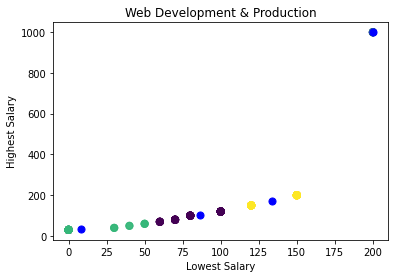

Data distribution:
 3    583
0    222
2    171
1     59
Name: kmean, dtype: int64
Total data points: 1035
Engineering - Software Cluster locations
[[150.         200.        ]
 [200.         999.        ]
 [  7.77777778  34.73684211]
 [106.26072041 130.7890223 ]]


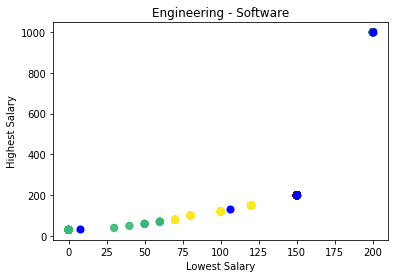

Data distribution:
 0    199
3    134
2    125
1     71
Name: kmean, dtype: int64
Total data points: 529
Other Cluster locations
[[100.90452261 123.46733668]
 [200.         999.        ]
 [ 16.48        39.92      ]
 [150.         200.        ]]


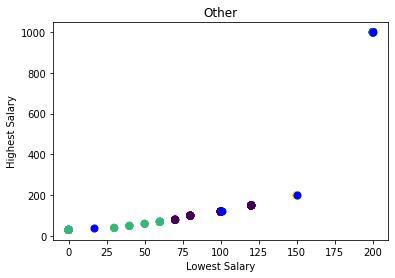

Data distribution:
 0    157
3     94
2     59
1     31
Name: kmean, dtype: int64
Total data points: 341
Engineering - Network Cluster locations
[[102.99363057 126.62420382]
 [200.         999.        ]
 [  6.44067797  34.06779661]
 [150.         200.        ]]


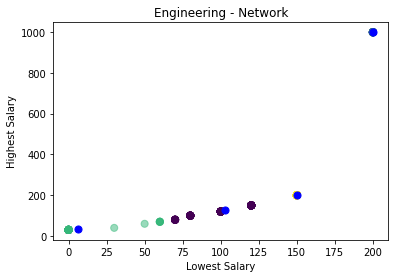

Data distribution:
 0    64
2    40
3    10
1     8
Name: kmean, dtype: int64
Total data points: 122
Team Leaders Cluster locations
[[105.625  130.3125]
 [200.     999.    ]
 [150.     200.    ]
 [  0.      30.    ]]


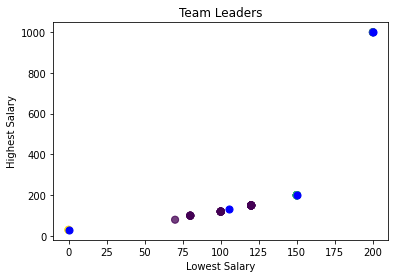

Data distribution:
 2    206
3    132
0     89
1     59
Name: kmean, dtype: int64
Total data points: 486
Testing & Quality Assurance Cluster locations
[[  8.53932584  35.16853933]
 [200.         999.        ]
 [101.50485437 124.41747573]
 [150.         200.        ]]


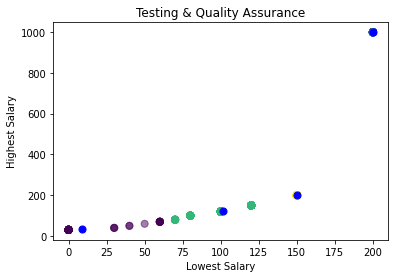

Data distribution:
 2    190
3    155
1     97
0     57
Name: kmean, dtype: int64
Total data points: 499
Management Cluster locations
[[  3.15789474  31.40350877]
 [200.         999.        ]
 [110.10526316 136.10526316]
 [150.         200.        ]]


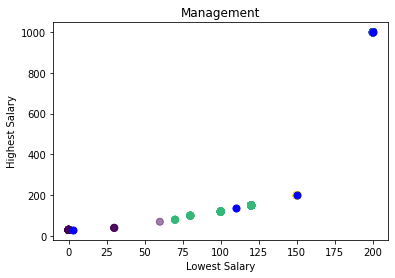

Data distribution:
 0    155
3    117
2     49
1     29
Name: kmean, dtype: int64
Total data points: 350
Database Development & Administration Cluster locations
[[137.61290323 179.35483871]
 [200.         999.        ]
 [  3.06122449  31.42857143]
 [ 84.1025641  101.11111111]]


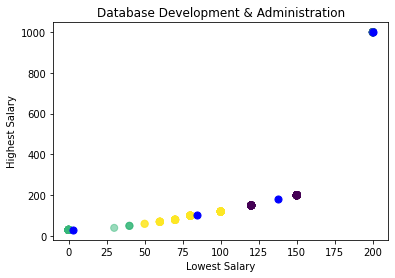

Data distribution:
 0    107
3     40
2     39
1      6
Name: kmean, dtype: int64
Total data points: 192
Telecommunications Cluster locations
[[ 77.10280374  91.68224299]
 [200.         999.        ]
 [134.61538462 174.35897436]
 [  6.5         32.5       ]]


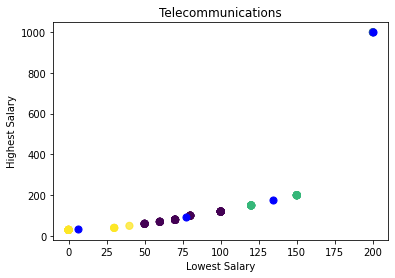

Data distribution:
 2    158
3     52
0     47
1     25
Name: kmean, dtype: int64
Total data points: 282
Product Management & Development Cluster locations
[[  7.23404255  34.25531915]
 [200.         999.        ]
 [106.89873418 131.83544304]
 [150.         200.        ]]


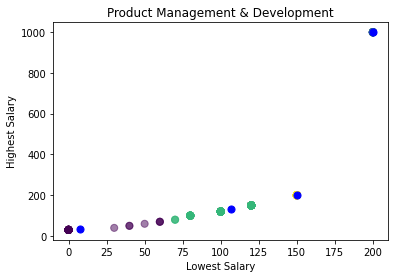

Data distribution:
 2    16
0    13
3     8
1     5
Name: kmean, dtype: int64
Total data points: 42
Technical Writing Cluster locations
[[138.46153846 180.76923077]
 [200.         999.        ]
 [ 78.75        95.        ]
 [  5.          32.5       ]]


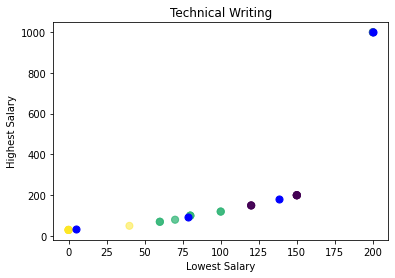

Data distribution:
 0    26
3    19
2    18
1     1
Name: kmean, dtype: int64
Total data points: 64
Engineering - Hardware Cluster locations
[[ 84.23076923 100.38461538]
 [200.         999.        ]
 [ 16.11111111  37.22222222]
 [132.63157895 171.05263158]]


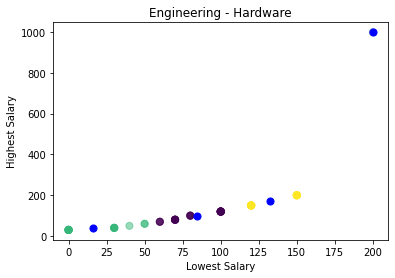

Data distribution:
 0    2
1    2
2    1
Name: kmean, dtype: int64
Total data points: 5
Computer Operators Cluster locations
[[200.  999. ]
 [  0.   30. ]
 [ 50.   60. ]
 [ 90.  423.6]]


<ipython-input-23-e2180da58d1f>:16: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  km = KMeans(n_clusters=4).fit(data171)


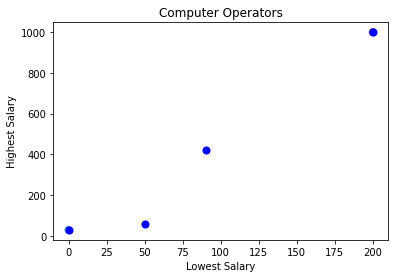

In [23]:
# Part 4: Case Studies
# Question 1 - Determine the best job sector for Mathew by analysing the ICT Sector
data17 = data[['Classification','SubClassification','LowestSalary', 'HighestSalary']].copy()
data17 = data17.loc[data17['Classification'] == 'Information & Communication Technology']
data17 = data17.drop(columns='Classification')
data17l = data17['SubClassification'].unique()

# Iterate through every subclassification and produce the cluster's and plot each point by lowest and highest salary
for i in data17l:
    # All of the following code is to produce scatter plots
    # Each of these shows the clustering of every salary and the appropriate cluster to determine the salary distribution
    # Filter data for selected SubClassification
    data171 = data17.loc[data17['SubClassification'] == i]
    data171 = data171.drop(columns='SubClassification')
    # Apply k means to the data and extract the appropriate cluster centers - 3 clusters have been defined
    km = KMeans(n_clusters=4).fit(data171)
    kcenters = km.cluster_centers_
    data171['kmean'] = km.labels_
    print("Data distribution:\n",data171['kmean'].value_counts())
    print("Total data points:", data171['kmean'].value_counts().sum())
    print (i, "Cluster locations")
    print(kcenters)
    # Place the data on the scatter plot and color based closest center.
    plt.scatter(data171['LowestSalary'], data171['HighestSalary'], c= km.labels_.astype(float), s=50, alpha=0.5)
    plt.scatter(kcenters[:, 0], kcenters[:, 1], c='blue', s=50)
    plt.title(i)
    plt.xlabel('Lowest Salary')
    plt.ylabel('Highest Salary')
    plt.show()


In [24]:
# From the data above the selected/recommended subsector for Mathew is Architect.
# Filter the sub classification architect to find the requirements which are required to enter jobs in this sub sector
data18 = data[['Classification','SubClassification','Requirement','FullDescription']].copy()
data18 = data18.loc[data18['Classification'] == 'Information & Communication Technology']
data18 = data18.drop(columns='Classification')
data18 = data18.loc[data18['SubClassification'] == 'Architects']

data18 = data18[data18['Requirement'].str.contains("skill")]
for i in data18['Requirement']:
    print(i)

UNIFY are seeking a Azure Specialist who wishes to broaden their client facing skills and be part of an outstanding Consulting Team
Opportunity for a Senior Portfolio Manager with excellent leadership skills to manage this large Portfolio of digital, IT & business projects
Solution Architect with Java and telco cloud skills
Experienced Solution Architect with Wireless Network skills required for key project within QLD Government.
An opportunity for a highly skilled Network Security Engineer to join a leading Australian organisation in a challenging technical environment. 
Leading client is seeking services of a skilled Cloud Solutions Architect 
A leading Financial Services organisation is seeking a Senior Solution Designer with advanced Tibco skills to join their team on a permanent basis
A leading Financial Services organisation is seeking a Senior Solution Designer with advanced Tibco skills to join their team on a permanent basis
Great contract with a global corporation! Utilise yo